In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import seaborn as sns
# special matplotlib argument for improved plots
#from matplotlib import rcParams
#sns.set_style("whitegrid")
#sns.set_context("poster")

In [3]:
import os
import commands

In [34]:
import pickle

## Topology

The network topology is as shown in the following figure.

The traffic load consists of 2 flows (node 0 to 4, node 1 to 5). Each service requires 2 distinct network functions.

#### Cost structure:

For each node $i$, the unit processing cost is $c_{i} = 1$. The allocation cost of processing resource is $w_{i} = [0, 1, 3, 6, 10]$, where $w_{i,k}$ is the cost of allocating $k$ resources. The processing capacity is given by $C_{i} = [0, 1, 2, 3, 4]$.

For each link $(i,j)$, the unit transmission cost is $c_{ij} = 1$. The allocation cost of the transmission link is $w_{ij} = [0, 1, 3, 6, 10]$, where $w_{ij,k}$ is the cost of allocating $k$ resources. The capacity is given by $C_{i} = [0, 1, 2, 3, 4]$.

#### Input traffic rates:

Each flow has arrival rate of 2 packets/slot.

(Note that each node and each link has the maximum processing/transmission capacity up to 4 packets/slot, we maay consider this scenario as 50% workload)

(0.1, 0.9)

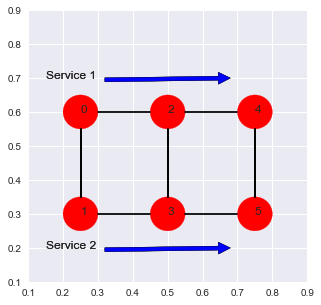

In [4]:
plt.figure(figsize=(5,5))
ax = plt.gca()
for i in xrange(2):
    for j in xrange(3):
        circle = plt.Circle((0.25*(j+1), 0.3*(i+1)), 0.05, color='r')
        ax.add_artist(circle)
        ax.annotate(str((1-i)+2*j), (0.25*(j+1), 0.3*(i+1)))
        plt.plot([0.25*(j+1), 0.25*(j+1)], [0.35, 0.55], color='k')
    plt.plot([0.3, 0.45], [0.3*(i+1), 0.3*(i+1)], color='k')
    plt.plot([0.55, 0.7], [0.3*(i+1), 0.3*(i+1)], color='k')
    ax.annotate('Service 1', xy=(0.7, 0.7), xytext=(0.15, 0.7), arrowprops=dict(facecolor='blue', shrink=0.05))
    ax.annotate('Service 2', xy=(0.7, 0.2), xytext=(0.15, 0.2), arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlim((0.1,0.9))
plt.ylim((0.1,0.9))

In [61]:
# Run simulation and plot simulation statistics
def test(N, t, deltar, costr, policy, V):
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' costr=' + str(costr)
    sim_command += ' policy=' + policy + ' V=' + str(V) + ' logging=false'
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_costr_' + str(costr)
    sim_instance += '_' + policy + '_V_' + str(V)

    commands.getstatusoutput(sim_command)    
    
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')
    
    node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]
    link_rate_columns = schedule.columns[[('rate' in x and 'link' in x) for x in schedule.columns]]

    #plt.figure()
    #schedule[node_rate_columns].head(1000).plot()
    
    plt.figure()
    fig, axes = plt.subplots(1, 4, figsize=(15, 4));
    schedule[node_rate_columns].mean().plot(kind='bar', ylim=[0,4], ax=axes[0])
    plt.title('V = ' + str(V))
    
    schedule[link_rate_columns].mean().plot(kind='bar', ylim=[0,4], ax=axes[1])    
    queue.sum(axis=1).plot(ax=axes[2])
    cost.sum(axis=1).plot(ax=axes[3])

    commands.getstatusoutput('rm ' + output_dir + 'schedule_' + sim_instance + '.csv')
    commands.getstatusoutput('rm ' + output_dir + 'queue_' + sim_instance + '.csv')
    commands.getstatusoutput('rm ' + output_dir + 'cost_' + sim_instance + '.csv')
    
    
    print 'Mean queue length sum = ', queue.sum(axis=1)[(t/10):].mean()
    print 'Mean cost = ', cost.sum(axis=1)[(t/10):].mean()

    return schedule, queue, cost

## Adaptive DCNC with various parameter V

For the following simulations, we fix the duration of reconfiguration delay as $\Delta_r = 10$.

For each V, the subfigures indicate 

(a) mean process rate at each node (b) mean transmission rate at each link (c) evoluation of total queue length

In [6]:
N = 6
t = 300000
deltar = 10
costr = 0
V = 10.0
policy = 'ADCNC'

V =  1.0 , deltar =  1
Mean queue length sum =  398.517066667
Mean cost =  153.851077778
V =  2.0 , deltar =  1
Mean queue length sum =  518.321677778
Mean cost =  93.3264777778
V =  5.0 , deltar =  1
Mean queue length sum =  1228.66365556
Mean cost =  68.9314
V =  10.0 , deltar =  1
Mean queue length sum =  2314.22775926
Mean cost =  55.1213333333
V =  20.0 , deltar =  1
Mean queue length sum =  4194.31332222
Mean cost =  46.259262963
V =  50.0 , deltar =  1
Mean queue length sum =  9566.1361
Mean cost =  42.5649037037
V =  100.0 , deltar =  1
Mean queue length sum =  18937.5469728
Mean cost =  40.7110197531
V =  200.0 , deltar =  1
Mean queue length sum =  37131.2770951
Mean cost =  39.3517876543
V =  1.0 , deltar =  5
Mean queue length sum =  2717.41057778
Mean cost =  202.793922222
V =  2.0 , deltar =  5
Mean queue length sum =  2829.54734444
Mean cost =  180.823477778
V =  5.0 , deltar =  5


/Users/changhengwang/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mean queue length sum =  3319.32311111
Mean cost =  137.197455556
V =  10.0 , deltar =  5
Mean queue length sum =  4461.89584815
Mean cost =  114.516825926
V =  20.0 , deltar =  5
Mean queue length sum =  6571.09534815
Mean cost =  94.7914333333
V =  50.0 , deltar =  5
Mean queue length sum =  12096.6715519
Mean cost =  64.3643185185
V =  100.0 , deltar =  5
Mean queue length sum =  21271.9600494
Mean cost =  48.6134
V =  200.0 , deltar =  5
Mean queue length sum =  38715.7807506
Mean cost =  45.592091358
V =  1.0 , deltar =  10
Mean queue length sum =  6134.37105556
Mean cost =  206.154611111
V =  2.0 , deltar =  10
Mean queue length sum =  6254.99132222
Mean cost =  200.196277778
V =  5.0 , deltar =  10
Mean queue length sum =  6779.98237778
Mean cost =  166.179422222
V =  10.0 , deltar =  10
Mean queue length sum =  7591.70042222
Mean cost =  137.810488889
V =  20.0 , deltar =  10
Mean queue length sum =  9821.75523333
Mean cost =  121.727696296
V =  50.0 , deltar =  10
Mean queue l

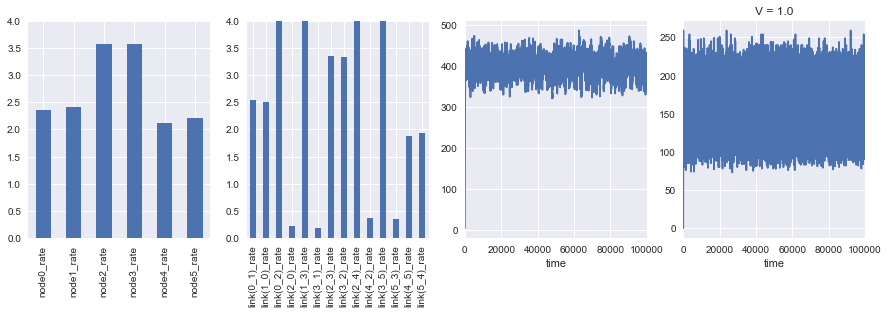

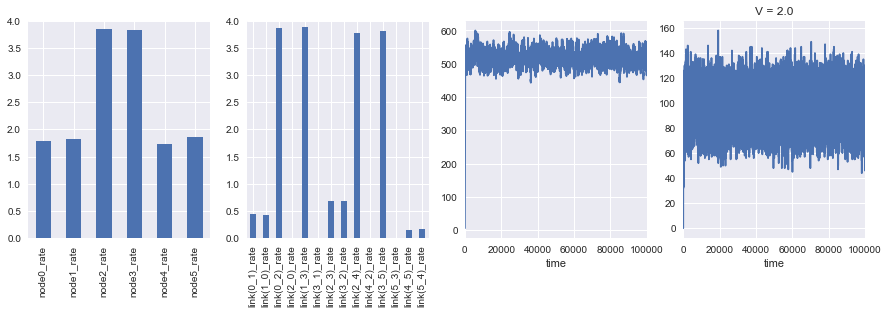

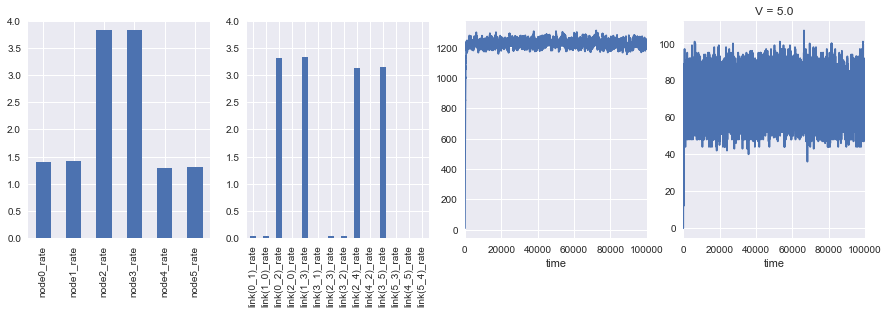

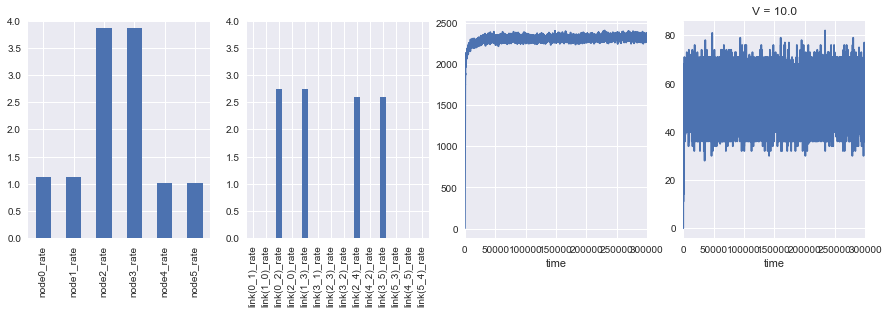

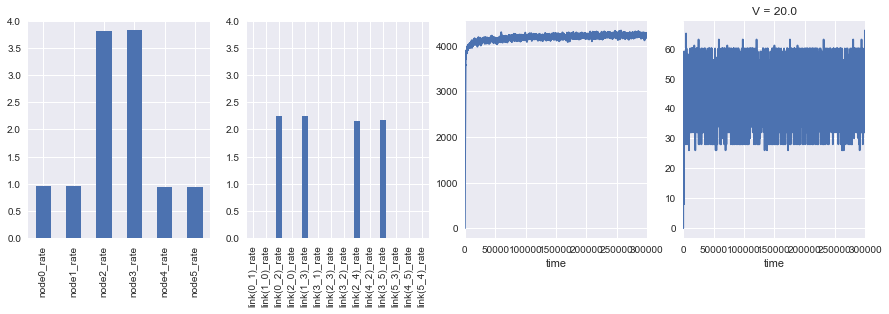

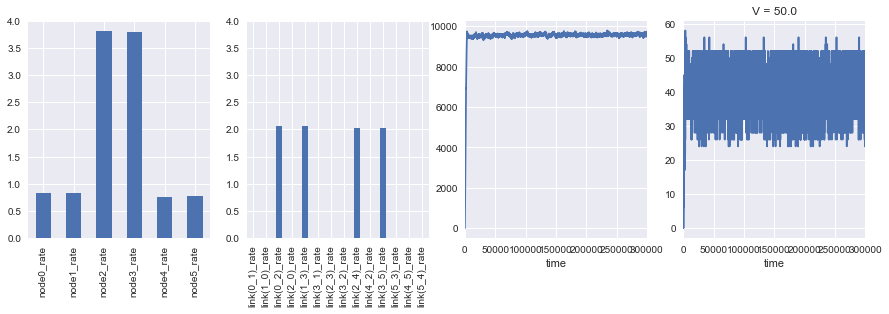

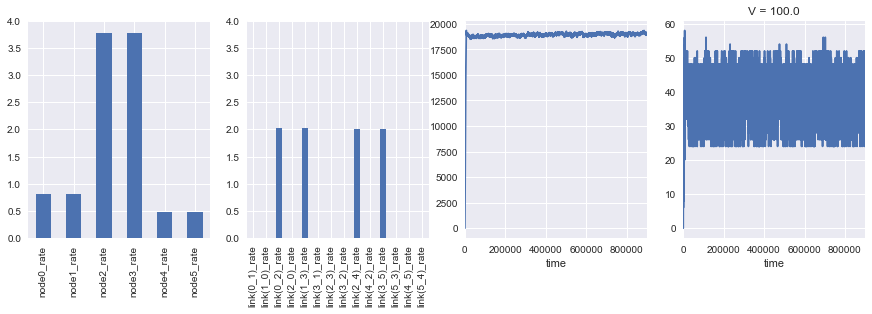

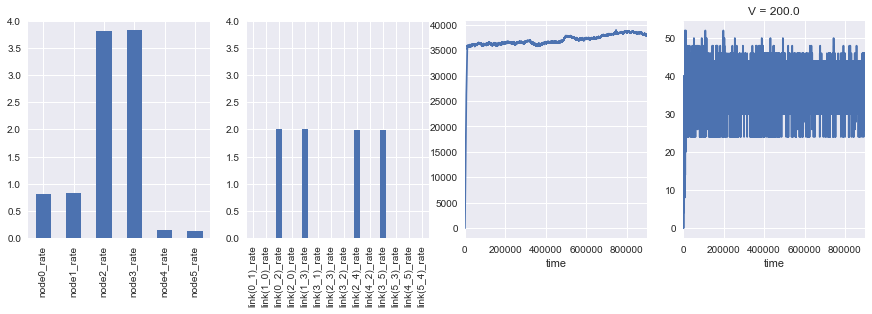

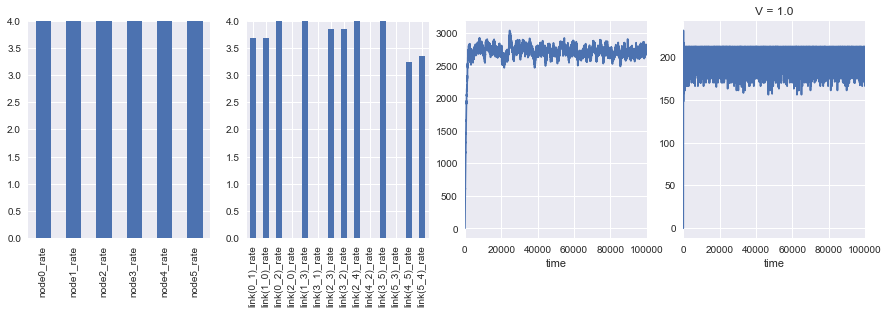

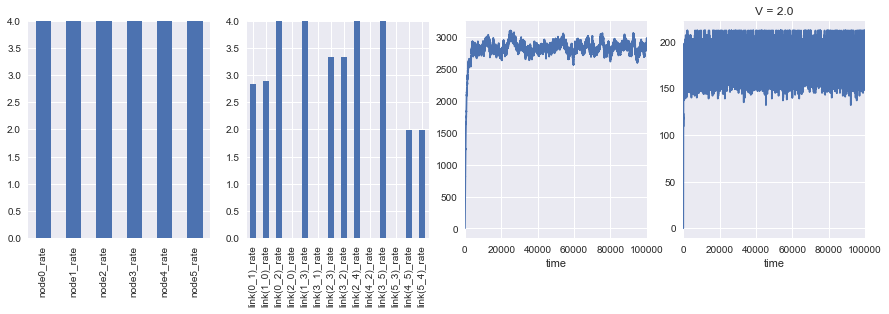

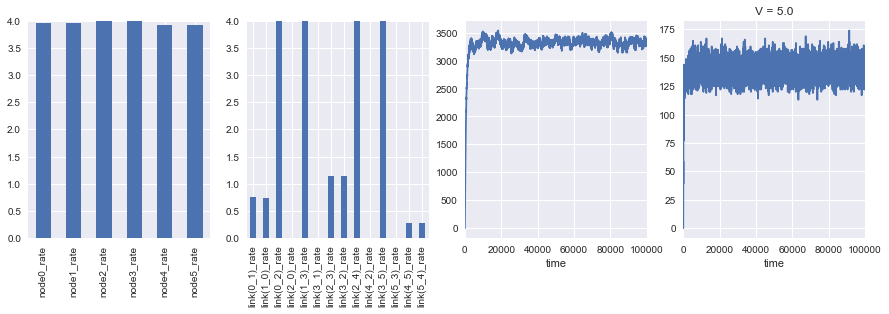

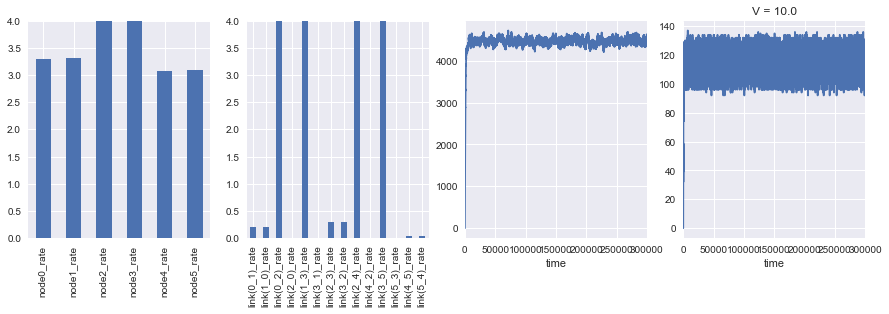

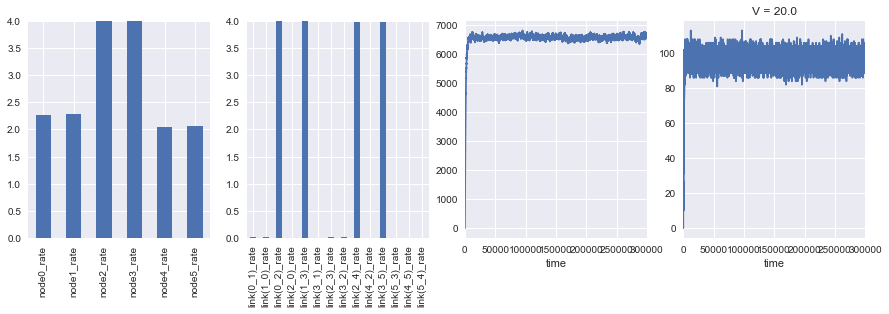

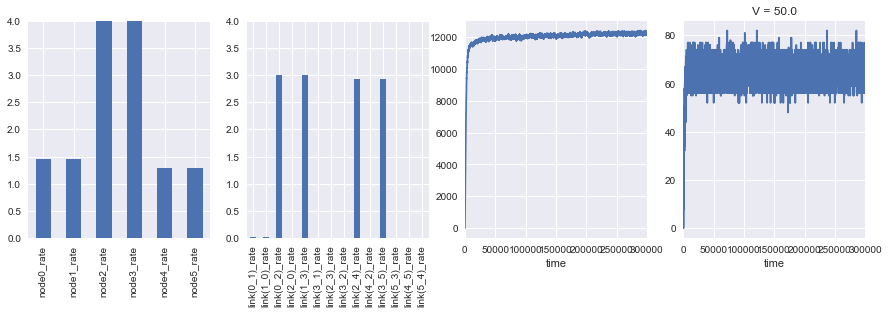

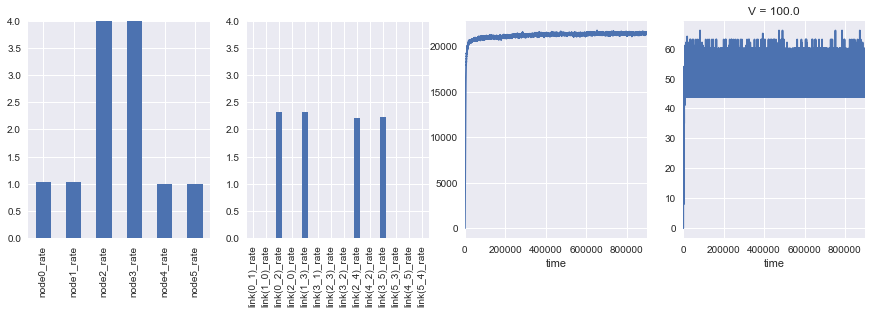

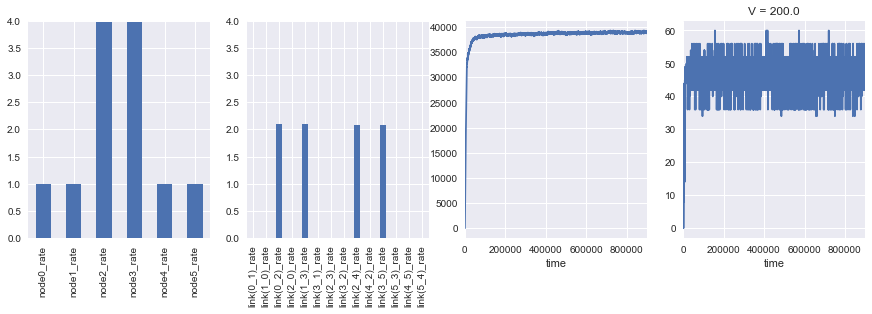

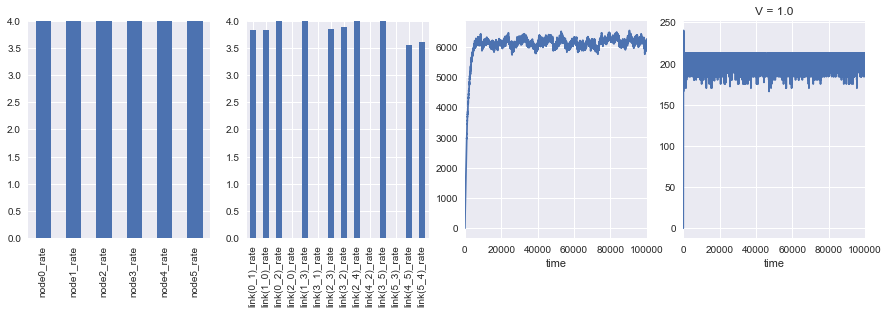

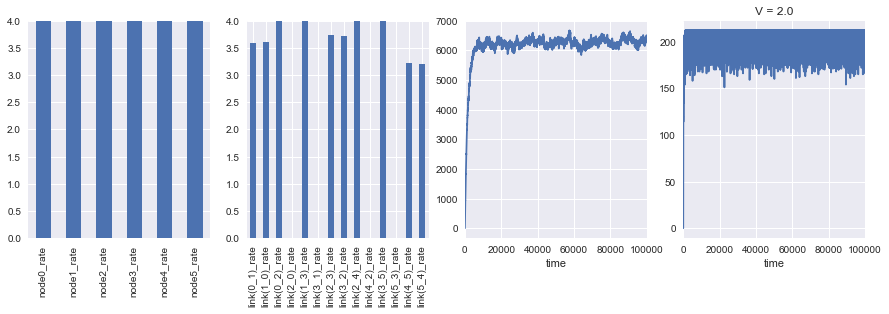

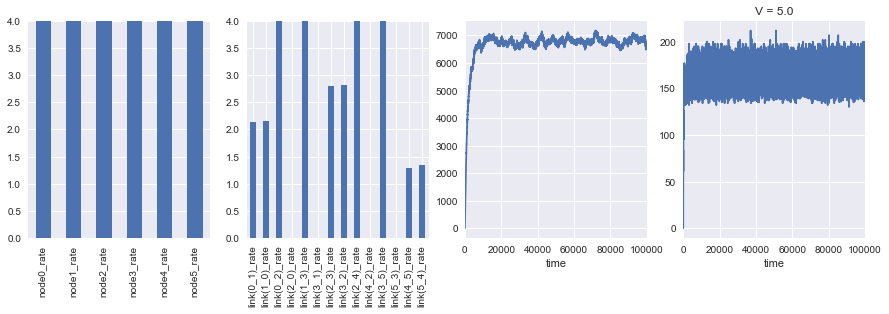

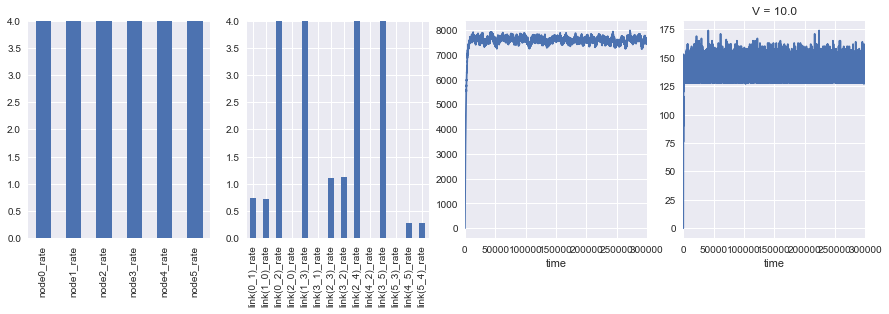

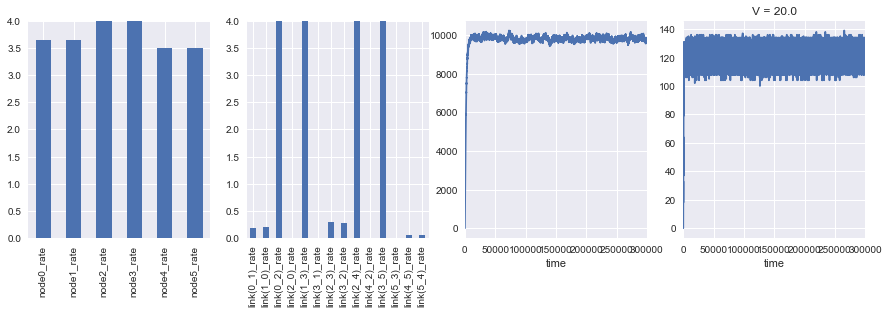

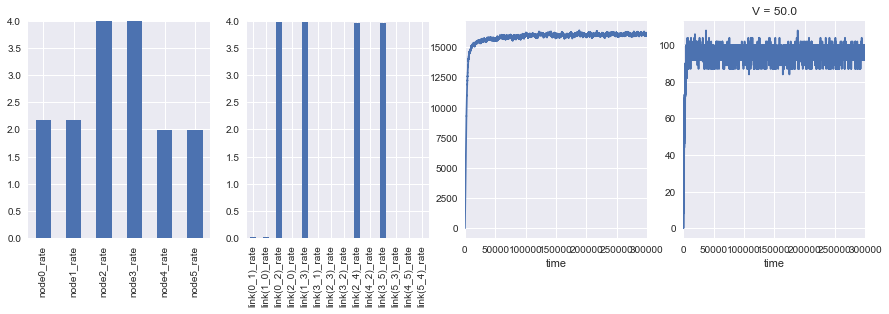

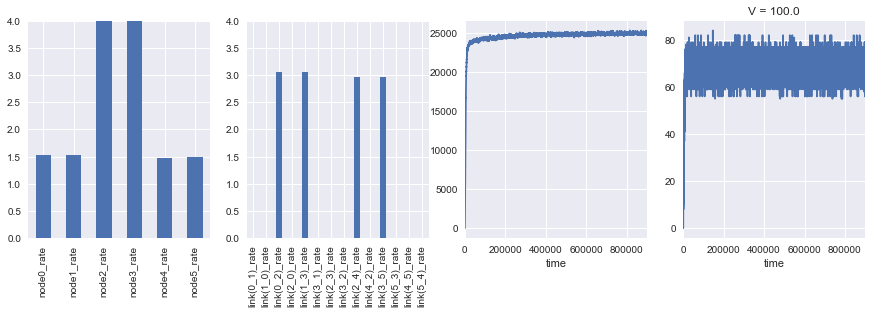

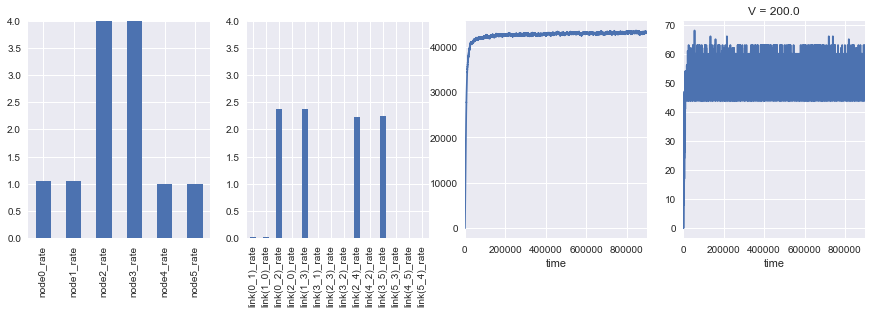

In [7]:
deltars = [1, 5, 10]
deltar_costs = []
deltar_queues = []
for deltar in deltars:
    costs = []
    queues = []
    Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1).mean())
        queues.append(queue.sum(axis=1).mean())
        del schedule, queue, cost
    
    deltar_costs.append(costs)
    deltar_queues.append(queues)

#### Cost - Delay tradeoff with varying V

In the following figures, we show the mean costs and the mean total queue lengths with varying V.

From the figures below, we could observe the cost-delay tradeoff under various paramter V.

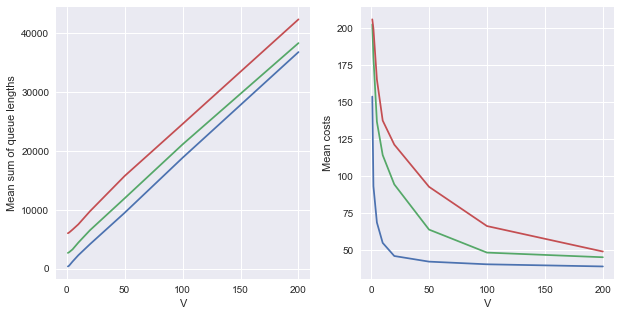

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in deltar_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in deltar_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

## Reconfiguration Costs

#### DCNC

In [81]:
N = 6
t = 300000
deltar = 0
costr = 10
V = 10.0
policy = 'DCNC'

V =  1.0 , deltar =  0 , costr =  0
Mean queue length sum =  362.803466667
Mean cost =  166.642255556
V =  2.0 , deltar =  0 , costr =  0
Mean queue length sum =  388.541711111
Mean cost =  65.4511777778
V =  5.0 , deltar =  0 , costr =  0
Mean queue length sum =  1208.97022222
Mean cost =  61.3835222222
V =  10.0 , deltar =  0 , costr =  0
Mean queue length sum =  2548.89085185
Mean cost =  60.4385925926
V =  20.0 , deltar =  0 , costr =  0
Mean queue length sum =  5127.11216667
Mean cost =  60.0977
V =  50.0 , deltar =  0 , costr =  0
Mean queue length sum =  11881.5920148
Mean cost =  59.9797740741
V =  100.0 , deltar =  0 , costr =  0
Mean queue length sum =  24405.7588432
Mean cost =  60.0073074074
V =  200.0 , deltar =  0 , costr =  0
Mean queue length sum =  41110.0033951
Mean cost =  59.9347666667
V =  1.0 , deltar =  0 , costr =  50
Mean queue length sum =  363.321633333
Mean cost =  831.205233333
V =  2.0 , deltar =  0 , costr =  50
Mean queue length sum =  388.433244444
Mean

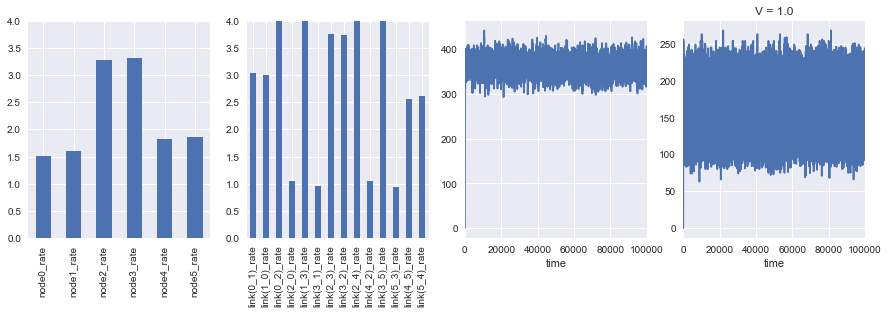

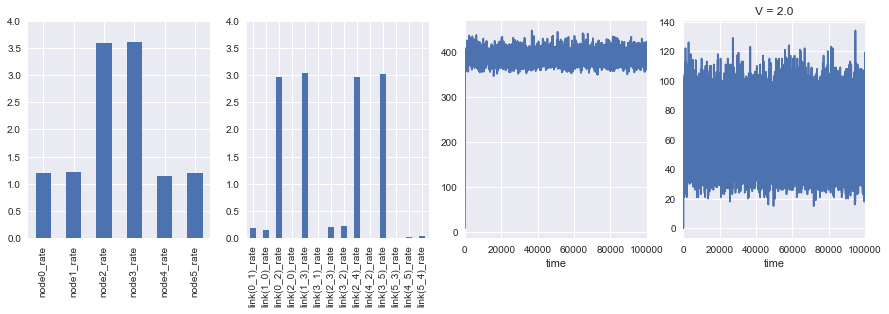

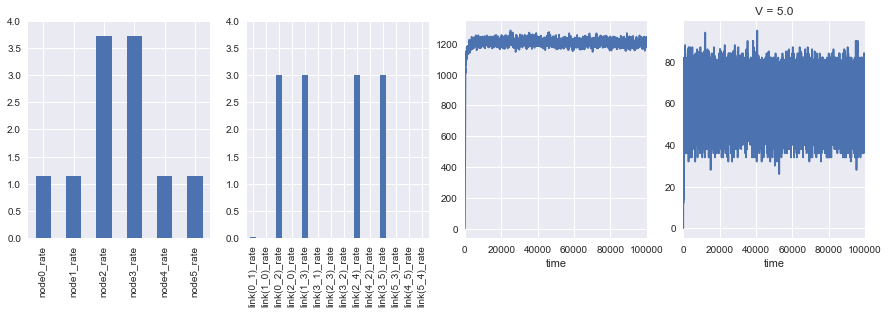

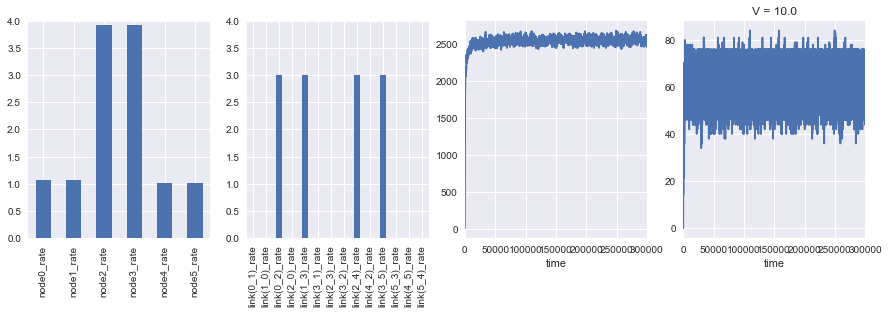

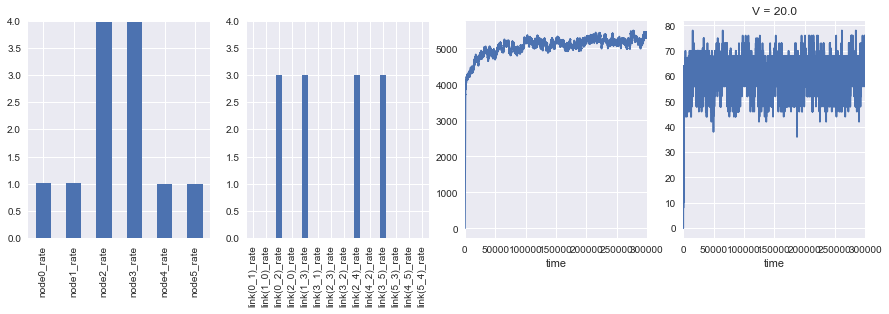

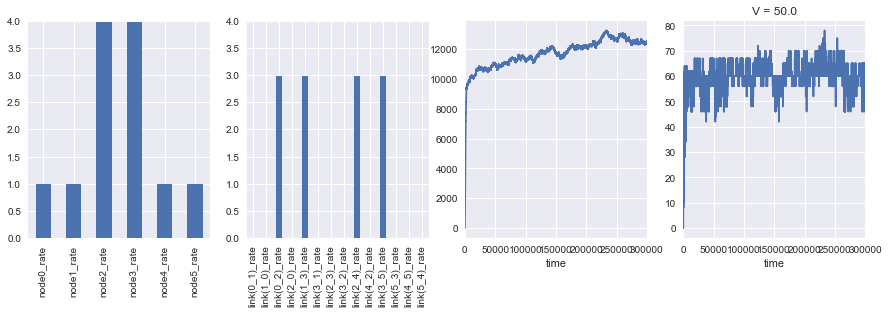

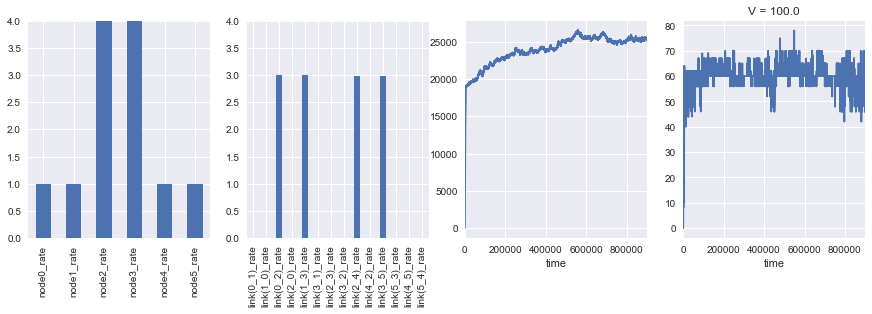

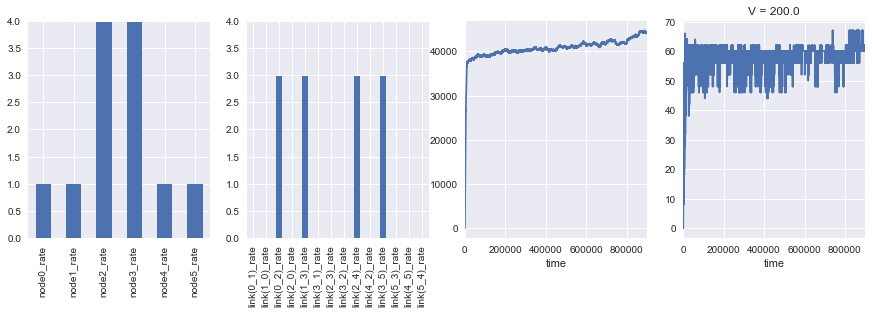

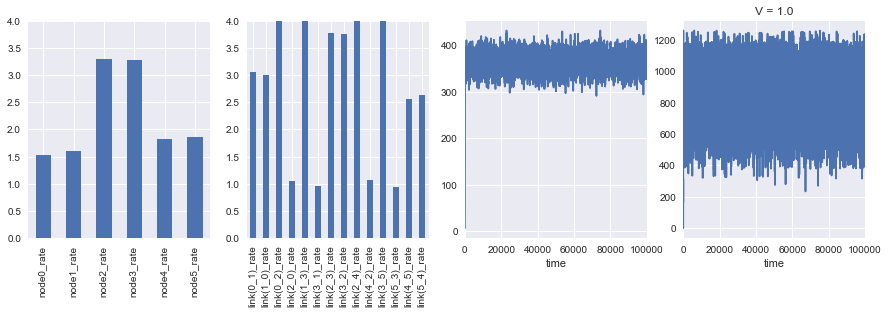

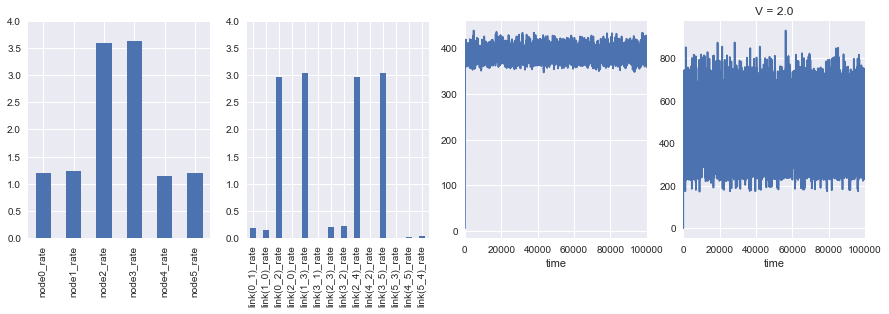

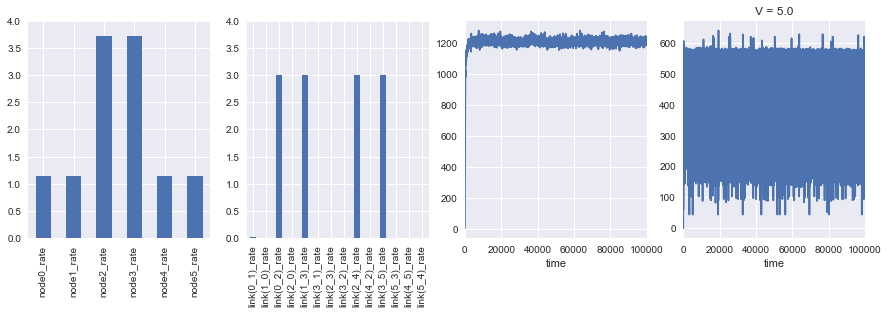

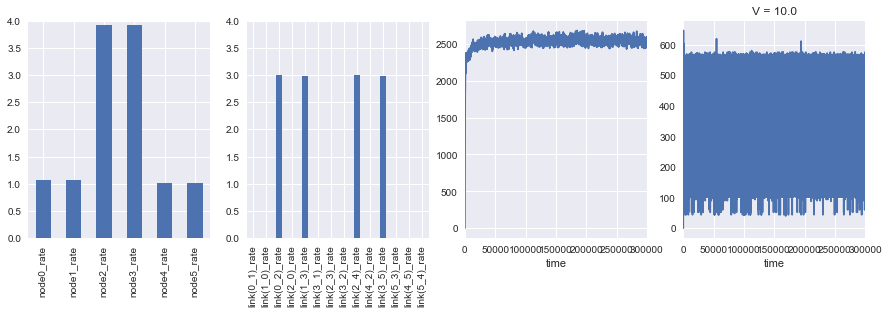

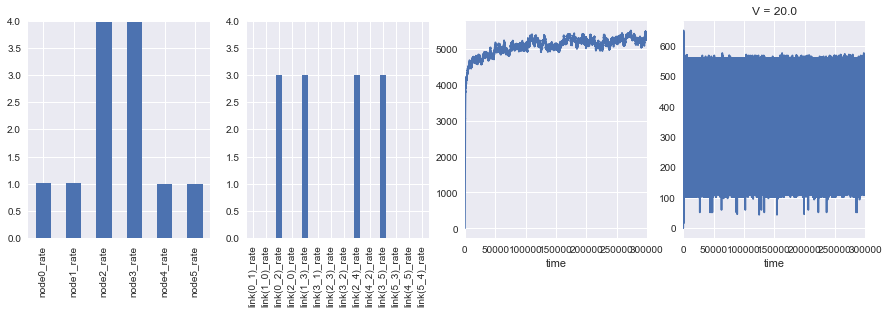

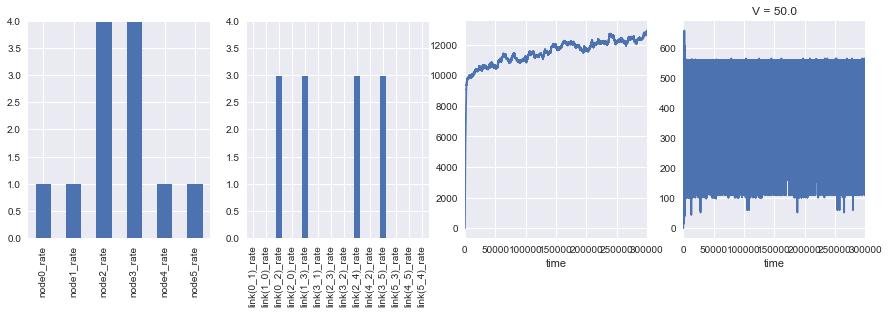

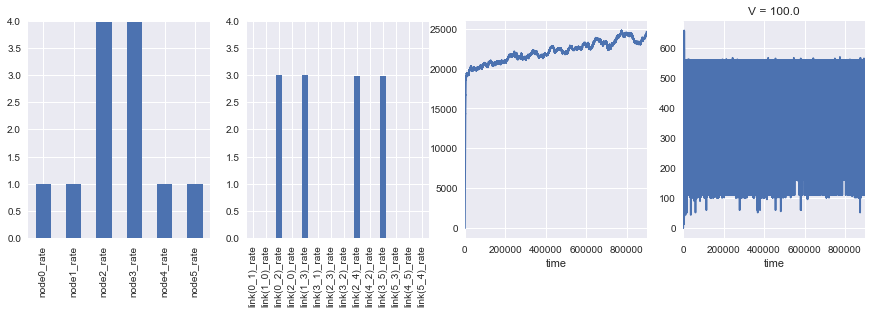

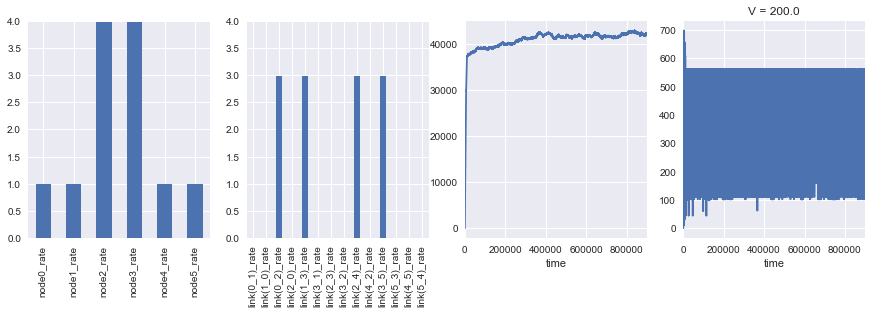

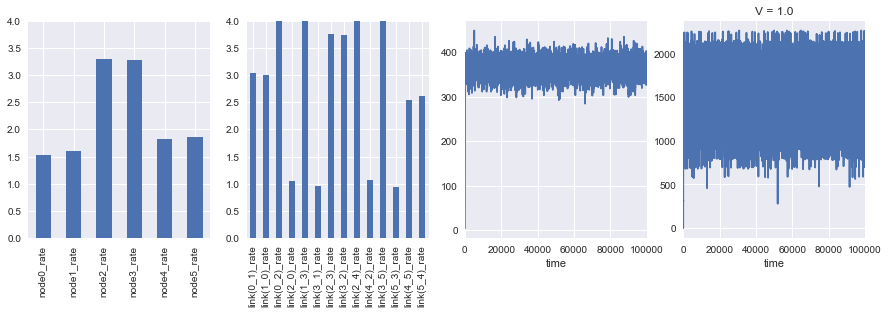

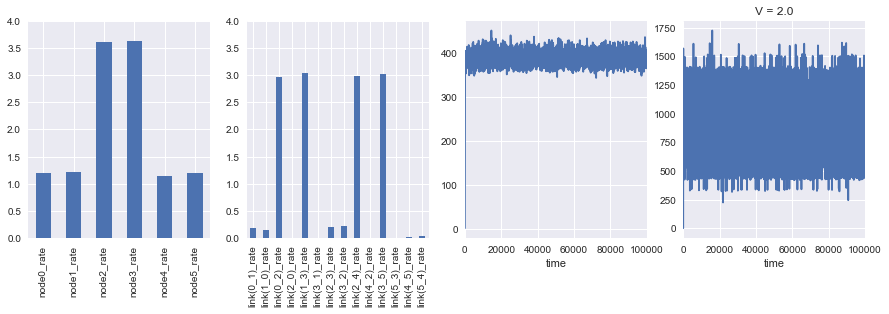

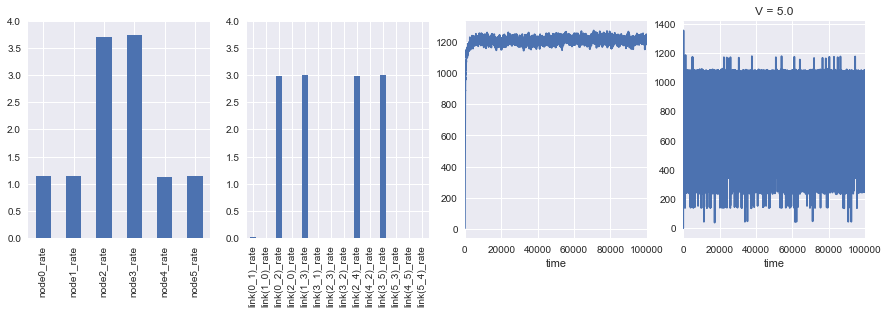

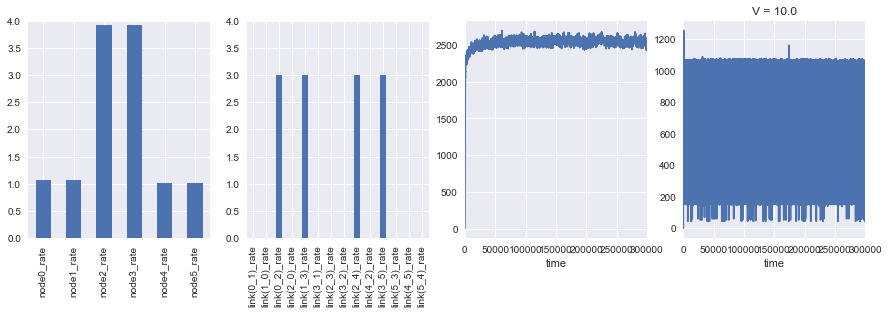

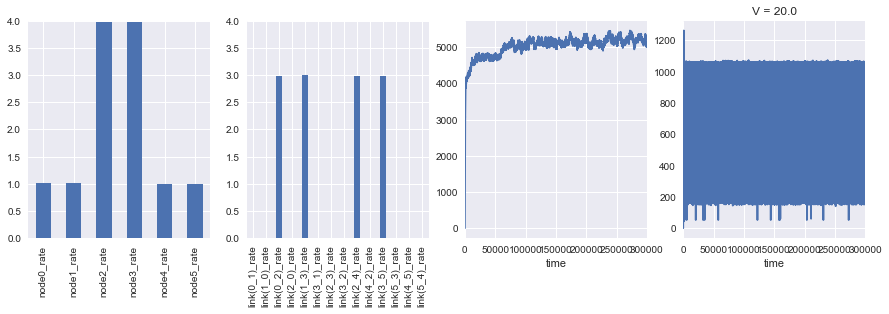

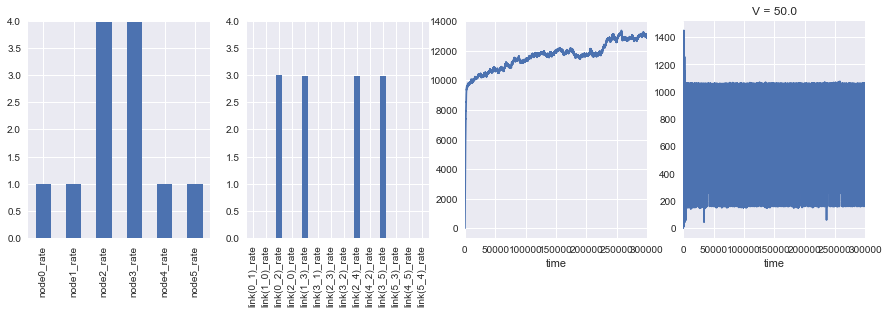

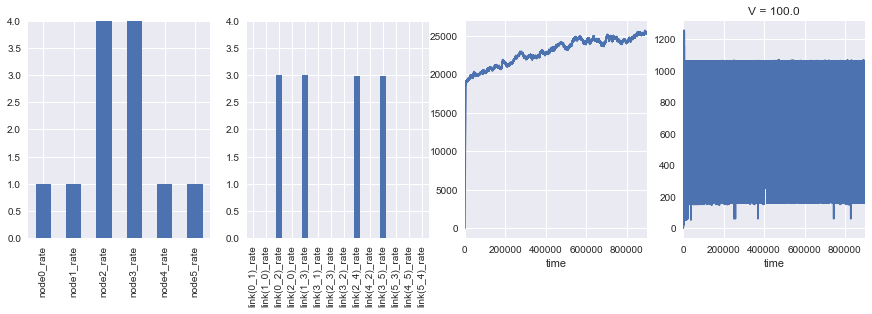

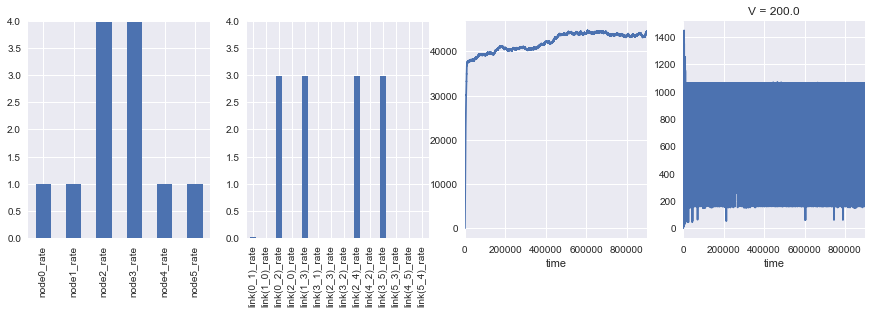

In [82]:
costrs = [0, 50, 100]
costr_costs = []
costr_queues = []
for costr in costrs:
    costs = []
    queues = []
    Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar, ', costr = ', costr
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1).mean())
        queues.append(queue.sum(axis=1).mean())
        del schedule, queue, cost
    
    costr_costs.append(costs)
    costr_queues.append(queues)

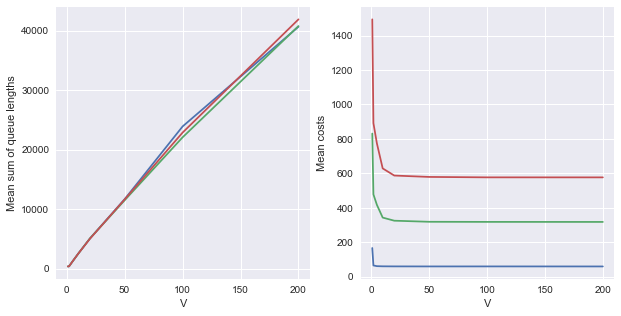

In [83]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in costr_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in costr_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

In [120]:
costr_costs = data_DCNC['costr_costs']
costr_queues = data_DCNC['costr_queues']
costrs = data_DCNC['costrs']

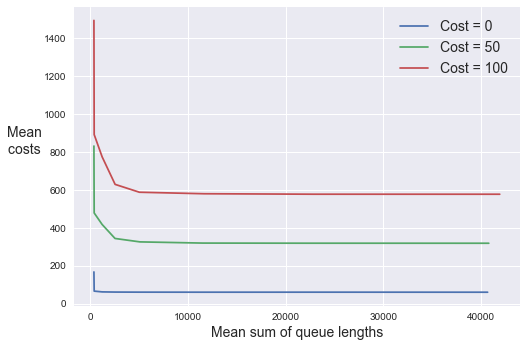

In [127]:
plt.figure()
for i in xrange(len(costrs)):
    plt.plot(costr_queues[i], costr_costs[i], label='Cost = '+str(costrs[i]))
    plt.xlabel('Mean sum of queue lengths', fontsize=14)
    plt.ylabel('Mean        \ncosts        ', fontsize=14, rotation=0)
    plt.legend(fontsize=14)

In [85]:
data = {'costr_costs': costr_costs, 'costr_queues': costr_queues, 'costrs': costrs, 'Vs': Vs}

with open('output/reconfiguration_cost_delay_cost_DCNC.out', 'wb') as outFile:
    pickle.dump(data, outFile)

#### ADCNC

In [86]:
N = 6
t = 300000
deltar = 0
costr = 10
V = 10.0
policy = 'ADCNC'

V =  1.0 , deltar =  0 , costr =  0
Mean queue length sum =  319.208488889
Mean cost =  162.6891
V =  2.0 , deltar =  0 , costr =  0
Mean queue length sum =  417.442455556
Mean cost =  66.7430444444
V =  5.0 , deltar =  0 , costr =  0
Mean queue length sum =  1400.11688889
Mean cost =  64.7010222222
V =  10.0 , deltar =  0 , costr =  0
Mean queue length sum =  2979.83157407
Mean cost =  65.4224851852
V =  20.0 , deltar =  0 , costr =  0
Mean queue length sum =  5730.84618889
Mean cost =  64.0995222222
V =  50.0 , deltar =  0 , costr =  0
Mean queue length sum =  13142.0395259
Mean cost =  60.5221037037
V =  100.0 , deltar =  0 , costr =  0
Mean queue length sum =  26118.667621
Mean cost =  60.2574333333
V =  200.0 , deltar =  0 , costr =  0
Mean queue length sum =  50109.1060519
Mean cost =  60.0500950617
V =  1.0 , deltar =  0 , costr =  50
Mean queue length sum =  317.835455556
Mean cost =  804.705733333
V =  2.0 , deltar =  0 , costr =  50
Mean queue length sum =  416.556477778
Mean

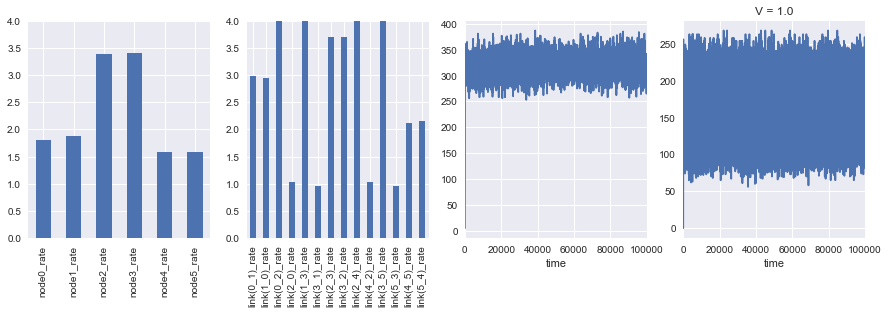

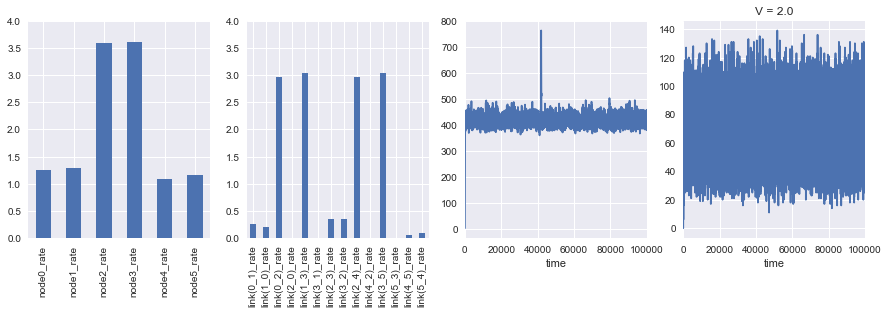

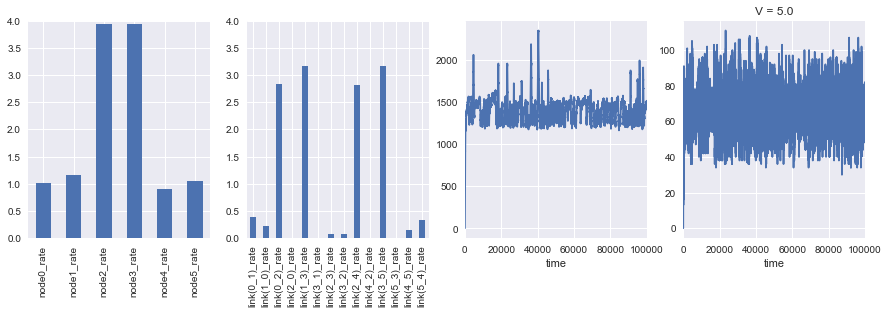

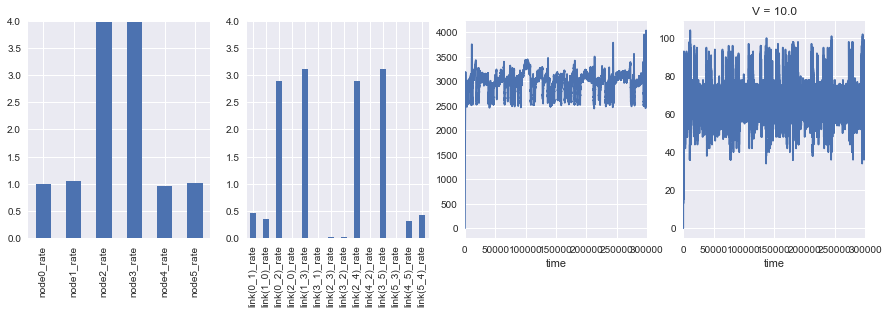

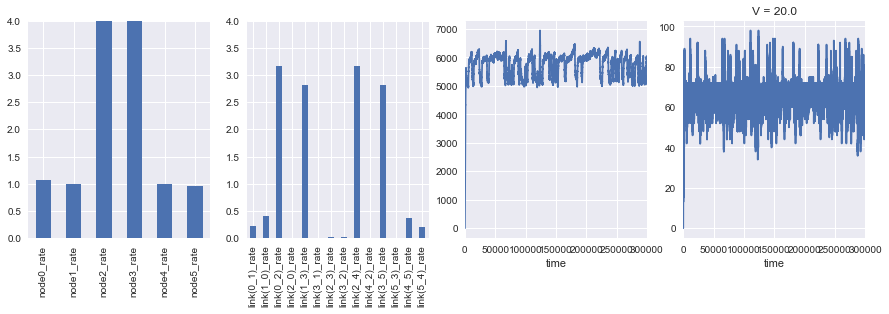

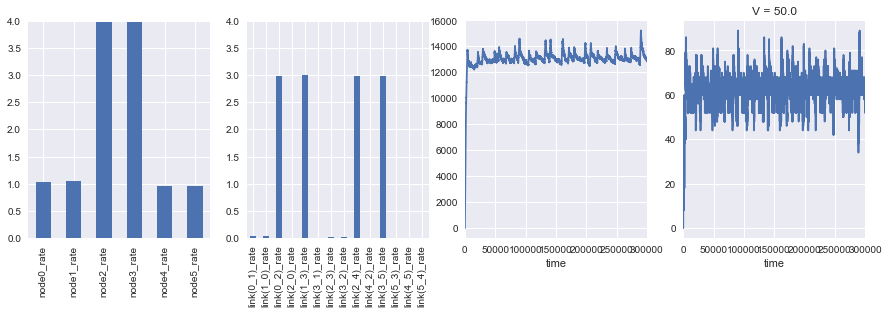

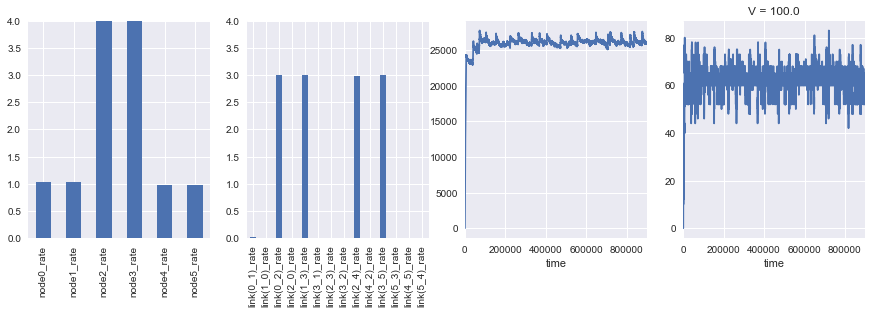

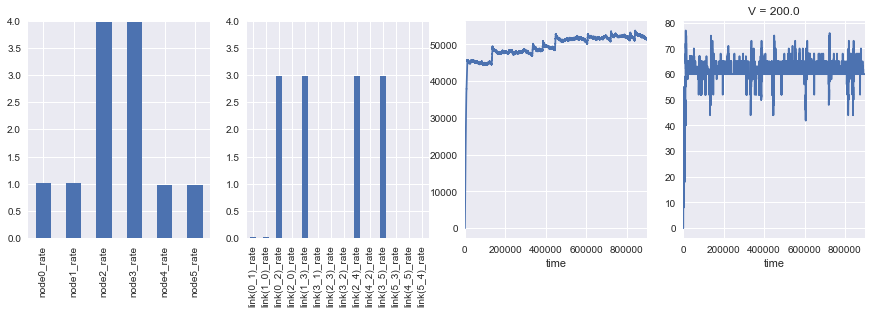

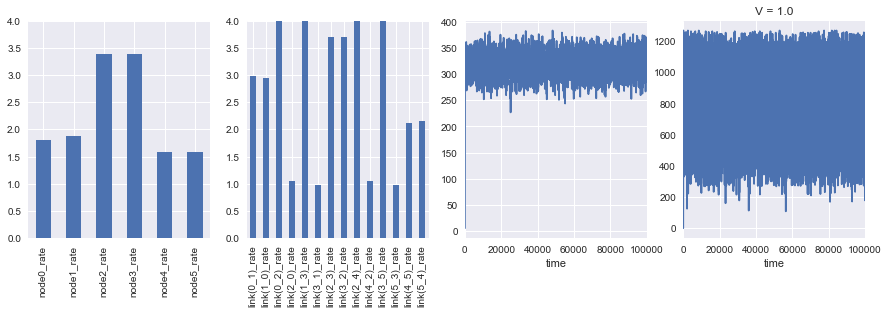

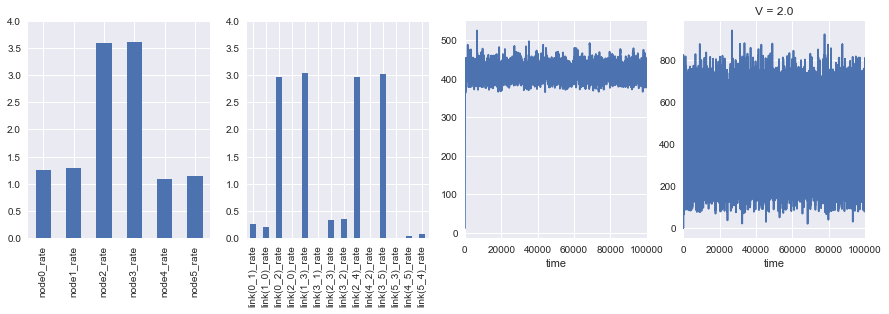

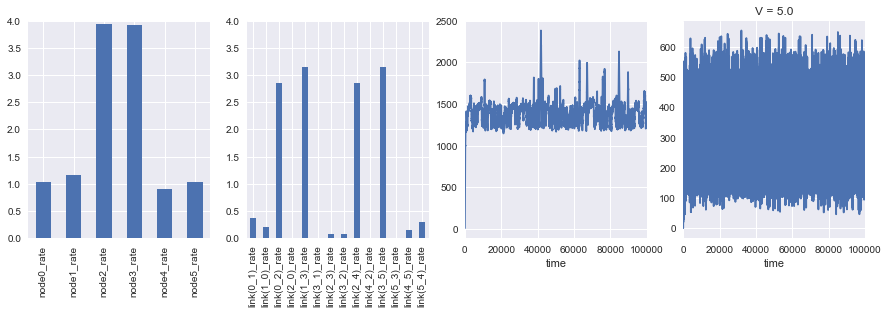

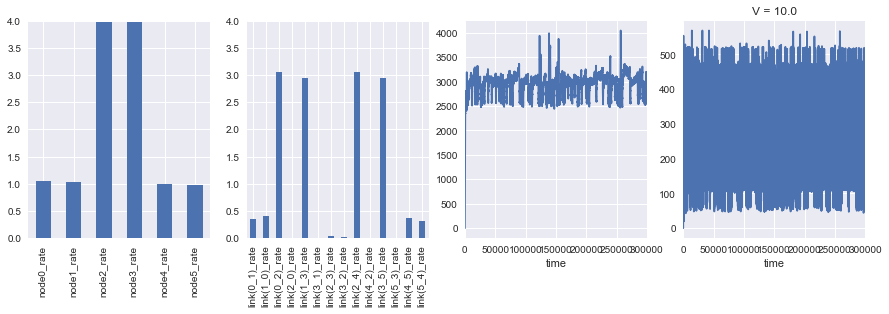

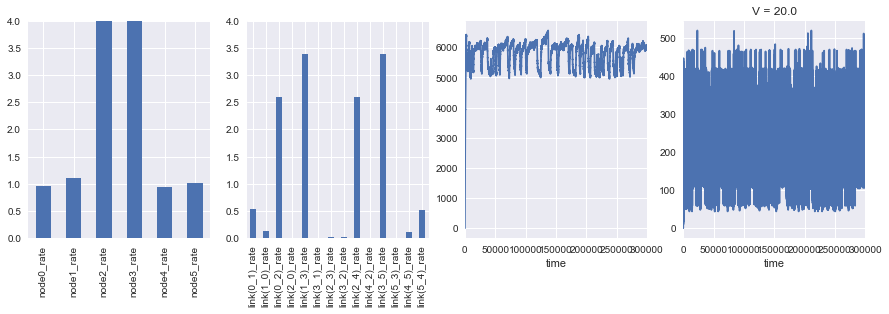

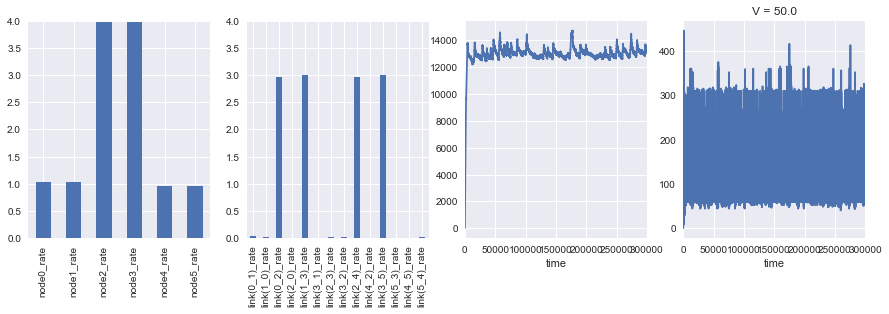

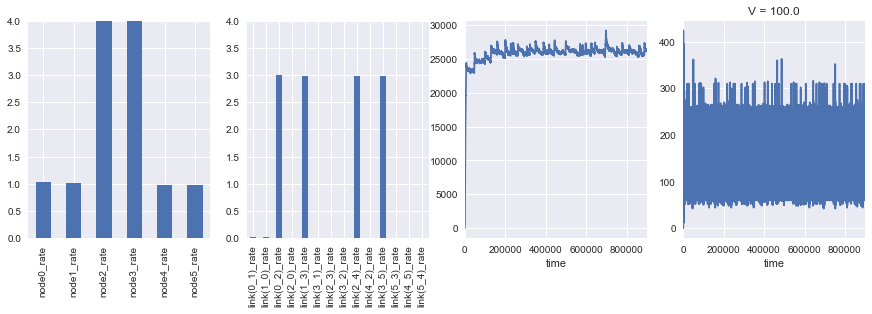

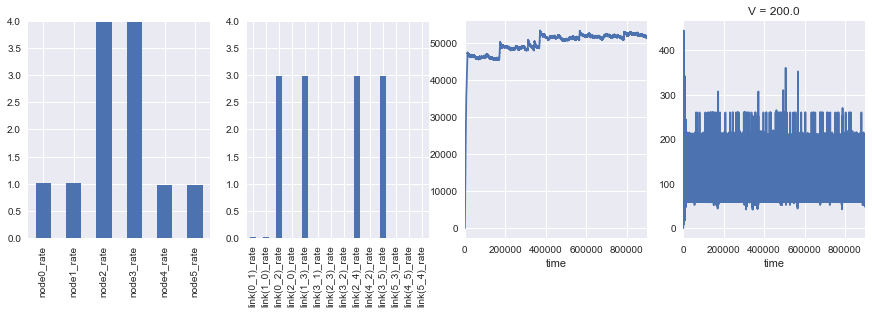

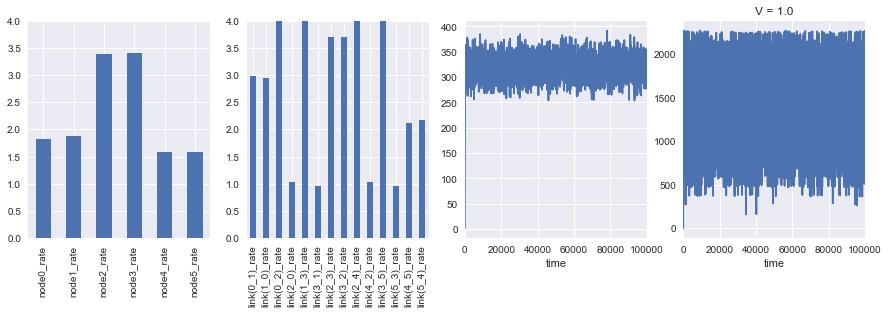

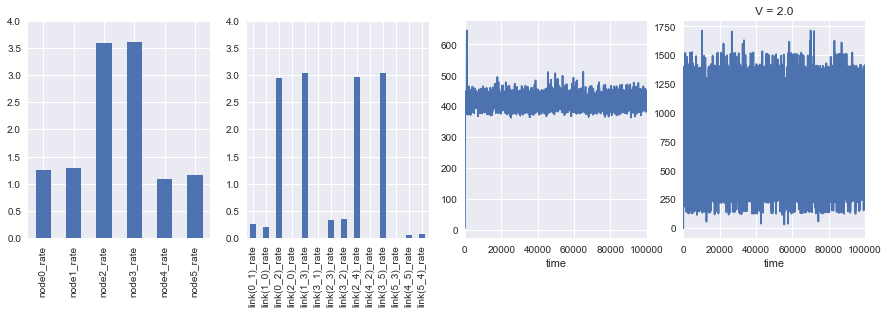

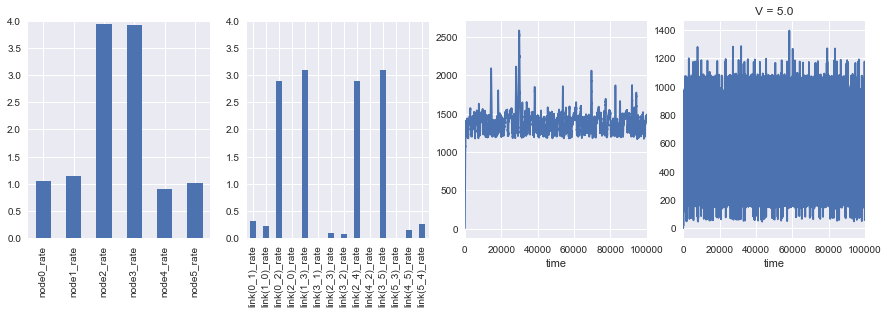

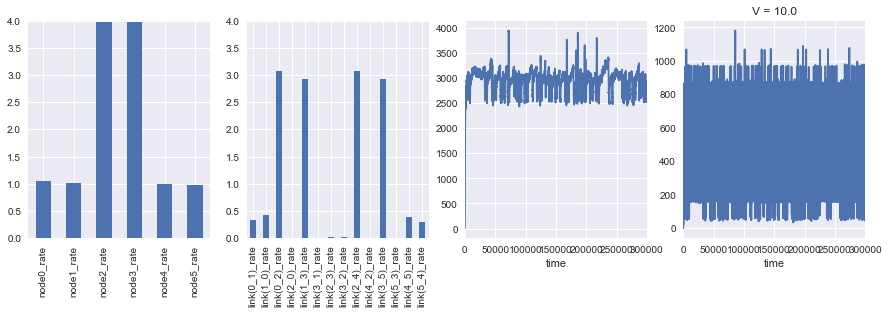

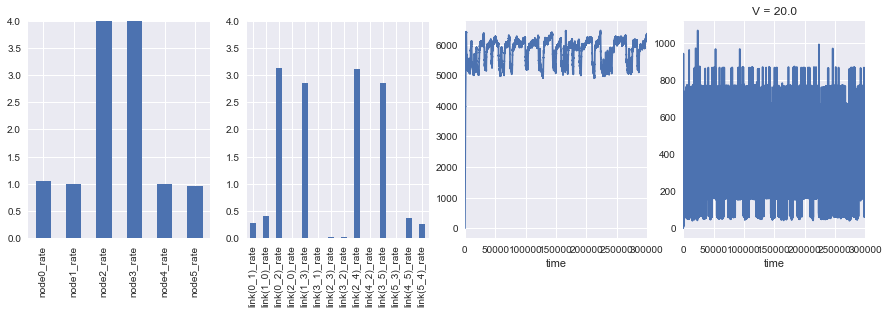

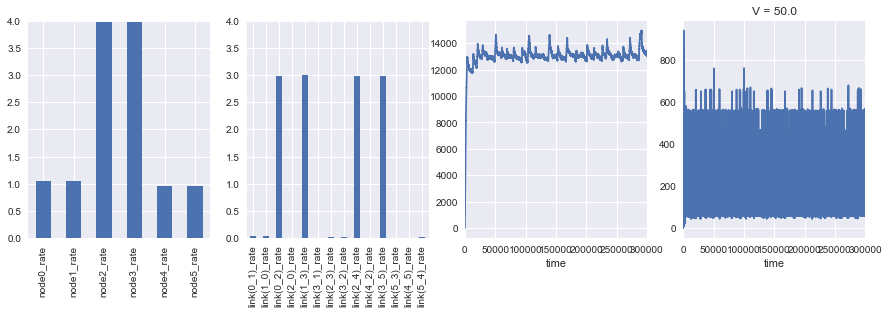

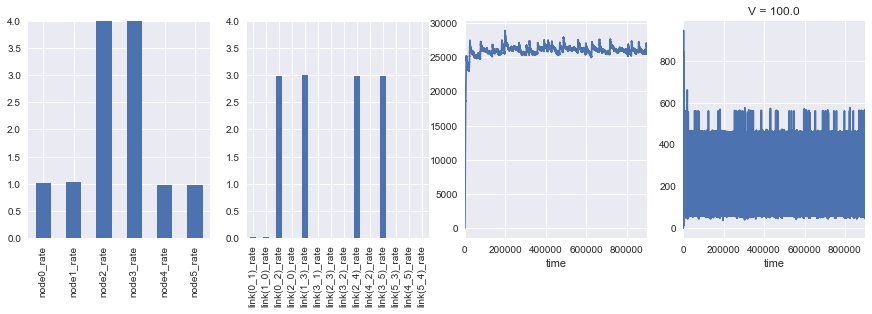

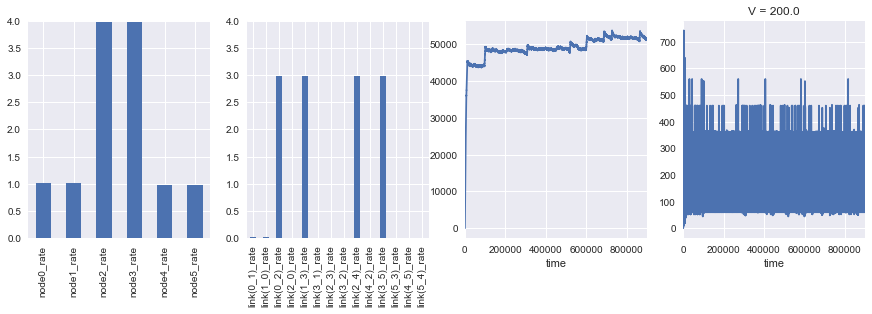

In [87]:
costrs = [0, 50, 100]
costr_costs = []
costr_queues = []
for costr in costrs:
    costs = []
    queues = []
    Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar, ', costr = ', costr
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1).mean())
        queues.append(queue.sum(axis=1).mean())
        del schedule, queue, cost
    
    costr_costs.append(costs)
    costr_queues.append(queues)

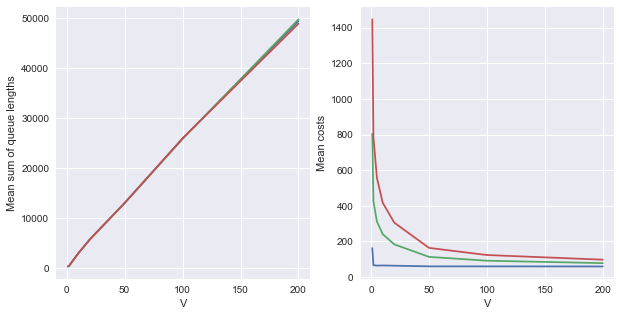

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in costr_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in costr_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

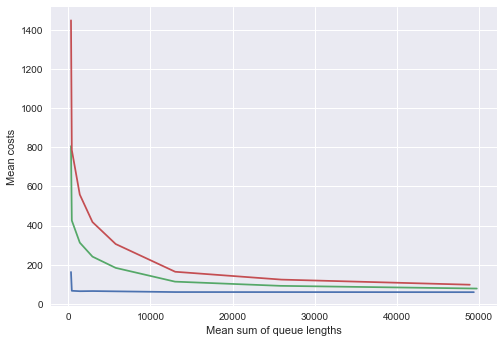

In [89]:
plt.figure()
for i in xrange(len(costrs)):
    plt.plot(costr_queues[i], costr_costs[i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')

In [90]:
data = {'costr_costs': costr_costs, 'costr_queues': costr_queues, 'costrs': costrs, 'Vs': Vs}

with open('output/reconfiguration_cost_delay_cost_ADCNC.out', 'wb') as outFile:
    pickle.dump(data, outFile)

In [91]:
with open('output/reconfiguration_cost_delay_cost_ADCNC.out', 'r') as inFile:
    data_ADCNC = pickle.load(inFile)
with open('output/reconfiguration_cost_delay_cost_DCNC.out', 'r') as inFile:
    data_DCNC = pickle.load(inFile)

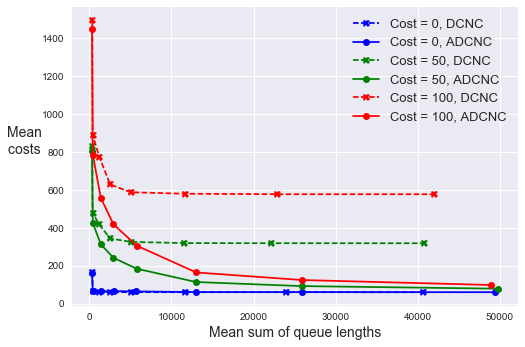

In [128]:
colors = ['b', 'g', 'r']
plt.figure()
for i in xrange(len(data_DCNC['costrs'])):
    plt.plot(data_DCNC['costr_queues'][i], data_DCNC['costr_costs'][i], c=colors[i], ls='dashed', marker='X', \
            label='Cost = '+ str(data_DCNC['costrs'][i]) + ', DCNC')
    plt.plot(data_ADCNC['costr_queues'][i], data_ADCNC['costr_costs'][i], c=colors[i], marker='o', \
            label='Cost = '+ str(data_ADCNC['costrs'][i]) + ', ADCNC')
    plt.xlabel('Mean sum of queue lengths', fontsize=14)
    plt.ylabel('Mean       \ncosts       ', rotation=0, fontsize=14)
    plt.legend(fontsize=13)

### Processing and transmission rate for each commodity

We now analyze the previous simulation results to check the (processing/transmission) rate of each commodity at different nodes/links.

For each node/link, commodity 0 (shown in gray color in the bar plots) indicates the time portion that the node/link is in reconfiguration.

In [9]:
def rate_plot(schedule, cost, V):
    # merge schedule and cost data
    cost.columns = [x+'_cost' for x in cost.columns]
    schedule = schedule.join(cost, how='inner')
    
    node_rates = pd.DataFrame()
    node_costs = pd.DataFrame()
    for n in xrange(N):
        node = schedule.columns[['node'+str(n) in x for x in schedule.columns]]
        df = schedule[node].copy()
        # Set the scheduled packet as NaN when in reconfiguration
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_packet'] = None
        # Set the process cost as 0 when in reconfiguration
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_px_cost'] = 0
        # Sum up the process and allocation cost
        df['node'+str(n)+'_cost'] = df['node'+str(n)+'_px_cost'] + df['node'+str(n)+'_resource_cost']
        df = df.fillna(0)
        df_rate = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_rate']]
        df_rate.index.name = ''
        df_cost = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_cost']]
        df_cost.index.name = ''

        if node_rates.empty:
            node_rates = df_rate
            node_costs = df_cost
        else:
            node_rates = node_rates.join(df_rate, how='outer')
            node_costs = node_costs.join(df_cost, how='outer')

    node_rates = node_rates.sort_index(ascending=False)
    node_rates = node_rates.stack()
    node_rates = node_rates.unstack(0)
    node_costs = node_costs.sort_index(ascending=False)
    node_costs = node_costs.stack()
    node_costs = node_costs.unstack(0)
    
    link_rates = pd.DataFrame()
    link_costs = pd.DataFrame()
    for l in schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate'):
        link = schedule.columns[[l in x for x in schedule.columns]]
        df = schedule[link].copy()
        # Set the scheduled packet as NaN when in reconfiguration
        df.loc[df[l+'_reconfig'] > 0, l+'_packet'] = None
        # Set the transmission cost as 0 when in reconfiguration
        df.loc[df[l+'_reconfig'] > 0, l+'_tx_cost'] = 0
        # Sum up the transmission and allocation cost
        df[l+'_cost'] = df[l+'_tx_cost'] + df[l+'_resource_cost']
        df = df.fillna(0)
        df_rate = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_rate']]
        df_rate.index.name = ''
        df_cost = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_cost']]
        df_cost.index.name = ''
        if link_rates.empty:
            link_rates = df_rate
            link_costs = df_cost
        else:
            link_rates = link_rates.join(df_rate, how='outer')
            link_costs = link_costs.join(df_cost, how='outer')

    link_rates = link_rates.sort_index(ascending=False)
    link_rates = link_rates.stack()
    link_rates = link_rates.unstack(0)
    link_costs = link_costs.sort_index(ascending=False)
    link_costs = link_costs.stack()
    link_costs = link_costs.unstack(0)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    fig.tight_layout(pad=6.0)
    node_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[0], colormap='nipy_spectral')
    axes[0].set_title('V = ' + str(V))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    link_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[1], colormap='nipy_spectral')
    axes[1].set_title('V = ' + str(V))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    node_costs.plot(kind='bar', stacked=True, ax=axes[2], colormap='nipy_spectral')
    axes[2].set_title('V = ' + str(V))
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    link_costs.plot(kind='bar', stacked=True, ax=axes[3], colormap='nipy_spectral')
    axes[3].set_title('V = ' + str(V))
    axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

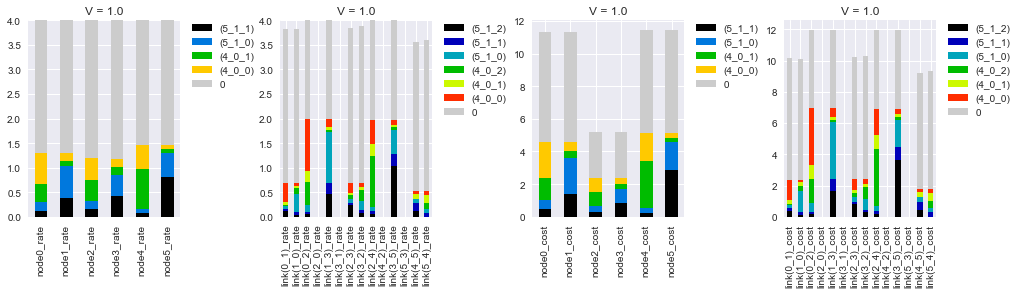

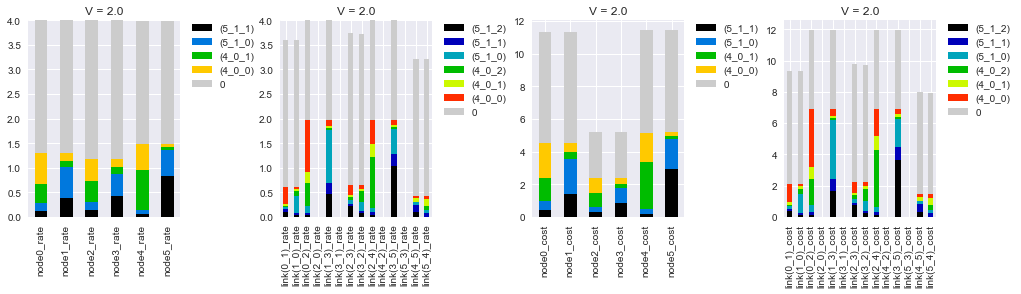

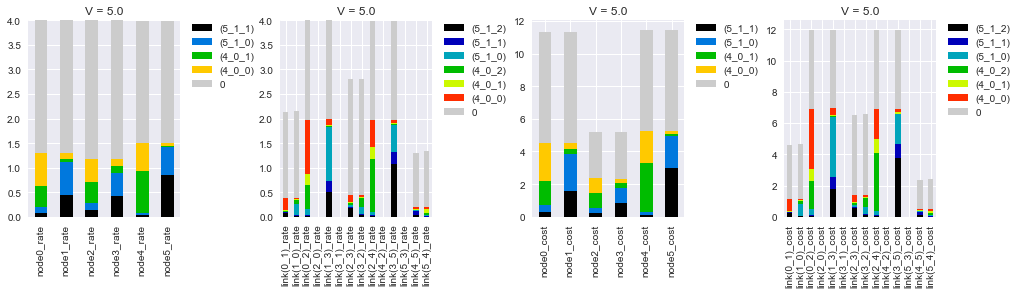

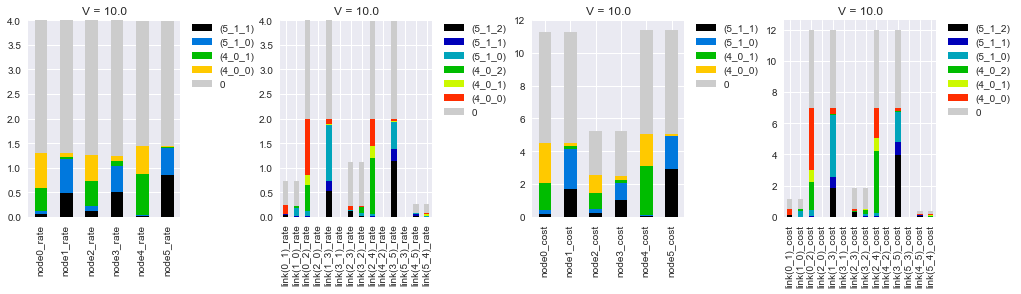

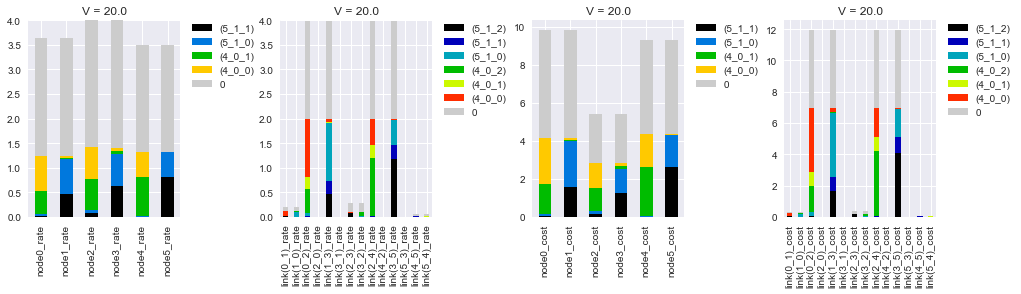

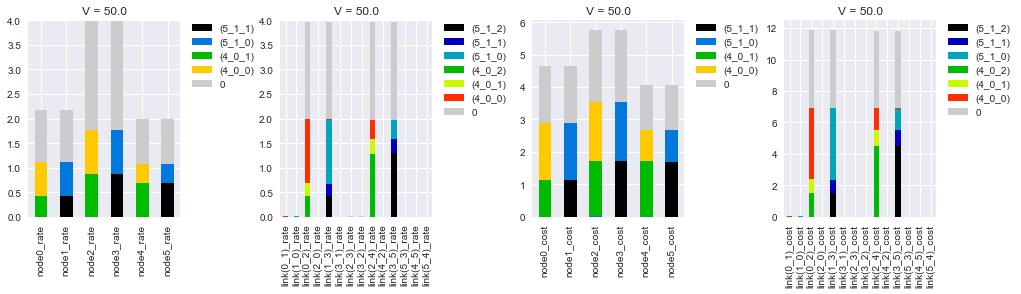

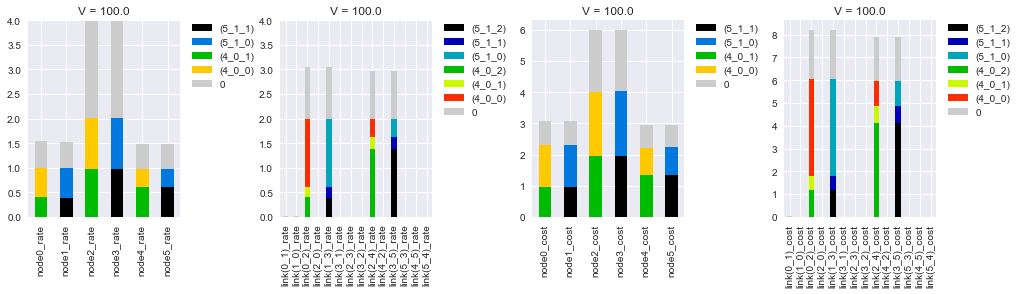

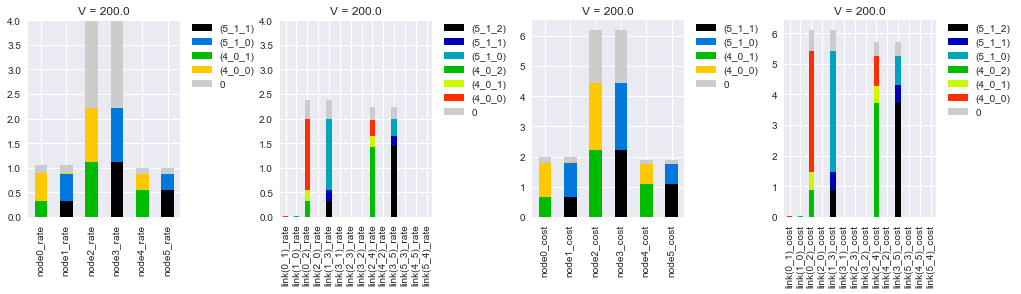

In [10]:
for V in Vs:
    t = int(100000 * (3**(np.floor(np.log10(V)))))
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, cost, V)

In the bar plots above, the gray area indicate the portion when one resource is in reconfiguration. In other words, during these portion, the resource is allocated but is not processing/transmitting due to reconfiguration delay.

Comparing the results under different parameter V, we may observe that larger V parameter induces less variation in the route selection and the NFV location, and in turn reduces the overhead wasted to reconfiguration. However, this is at the expense of larger queue length (delay), as indicated in the cost-delay tradeoff shown above.

## DCNC with various parameter V

In [53]:
N = 6
t = 1000000
deltar = 2
costr = 0
policy = 'DCNC'
V = 1.0

V =  1.0
Mean queue length sum =  357.111597778
Mean cost =  142.17493
V =  5.0
Mean queue length sum =  1250.68923444
Mean cost =  67.0028544444
V =  10.0
Mean queue length sum =  2495.56256
Mean cost =  61.7923655556
V =  50.0
Mean queue length sum =  10678.8223444
Mean cost =  60.3153655556
V =  100.0
Mean queue length sum =  20429.9494589
Mean cost =  60.1701788889


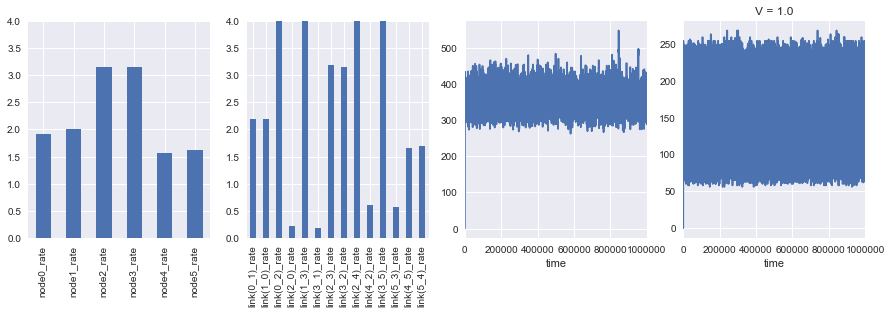

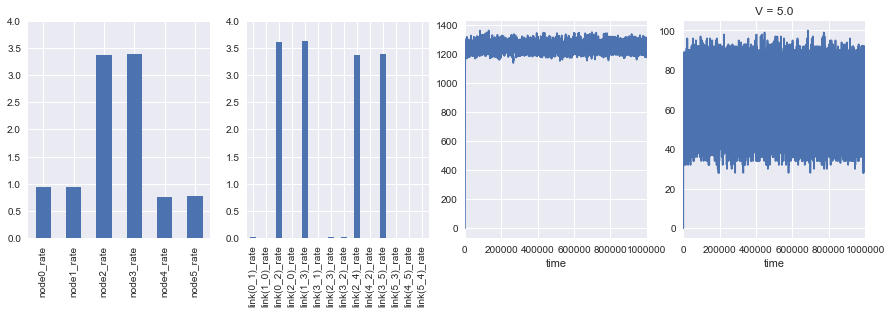

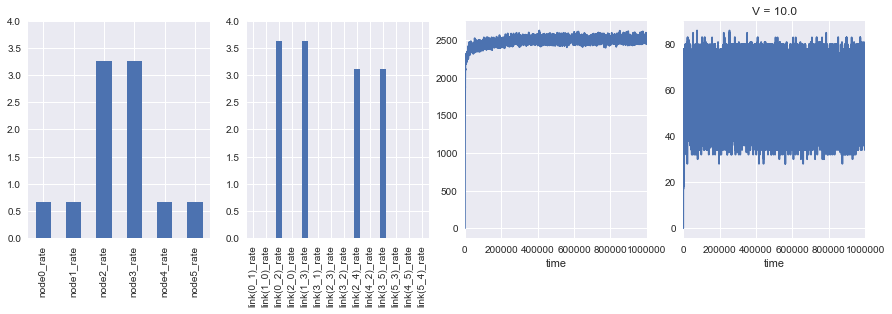

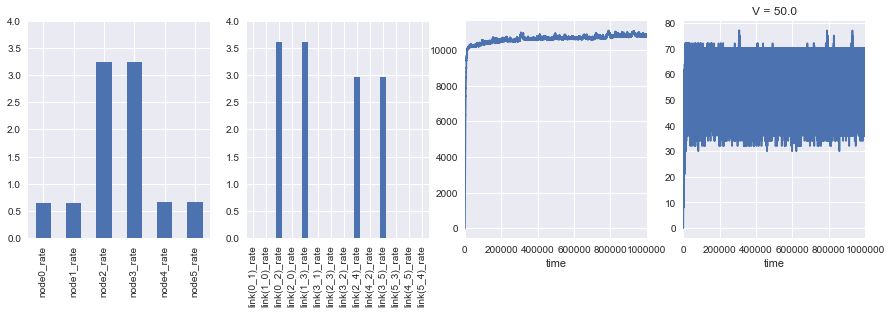

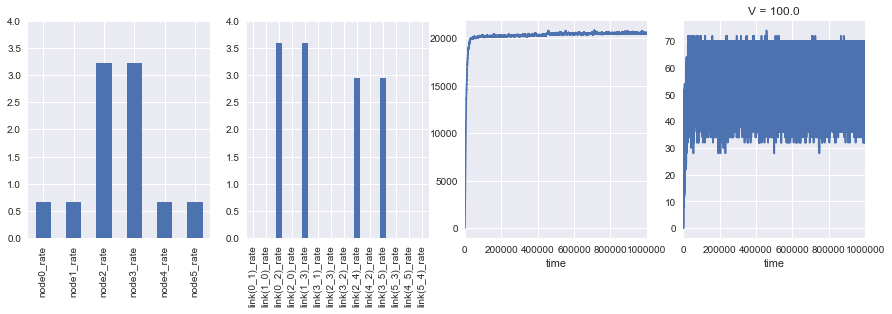

In [54]:
costs = []
queues = []
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
for V in Vs:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, costr, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

In [ ]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)

## Comparison with DCNC under no reconfiguration delay

Reconfiguration delay $\Delta_r = 0$

In [24]:
N = 6
t = 100000
deltar = 0
policy = 'DCNC'
V = 1.0

V =  1.0
Mean queue length sum =  287.902811111
Mean cost =  190.722833333
V =  5.0
Mean queue length sum =  1160.38832222
Mean cost =  38.2032444444
V =  10.0
Mean queue length sum =  2273.16604444
Mean cost =  37.9792777778
V =  50.0
Mean queue length sum =  10021.8512556
Mean cost =  37.8277333333
V =  100.0
Mean queue length sum =  19552.1407111
Mean cost =  37.9407555556


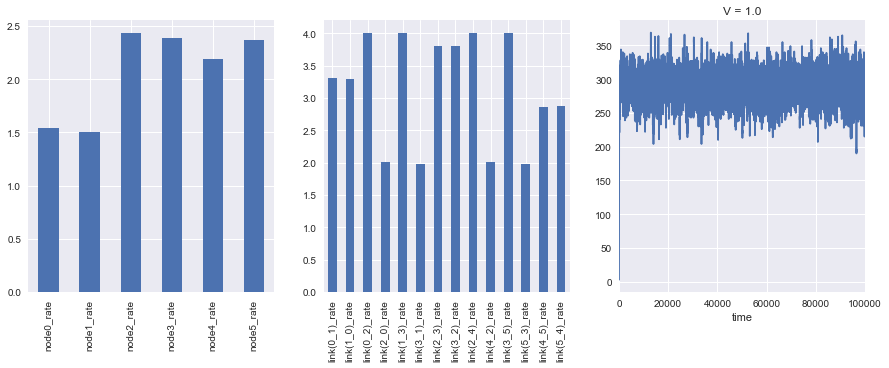

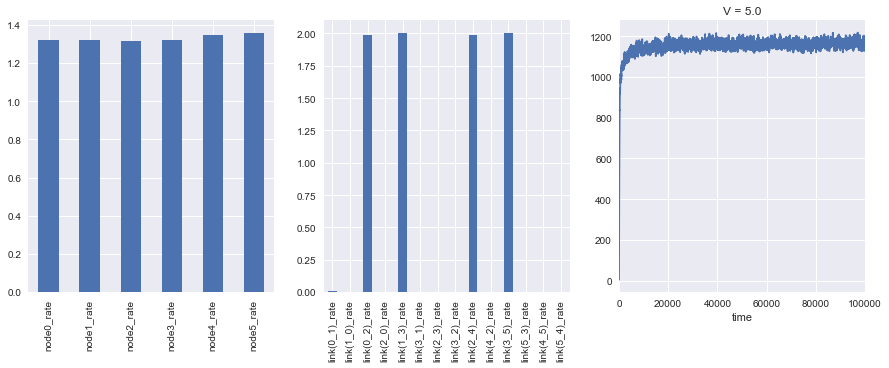

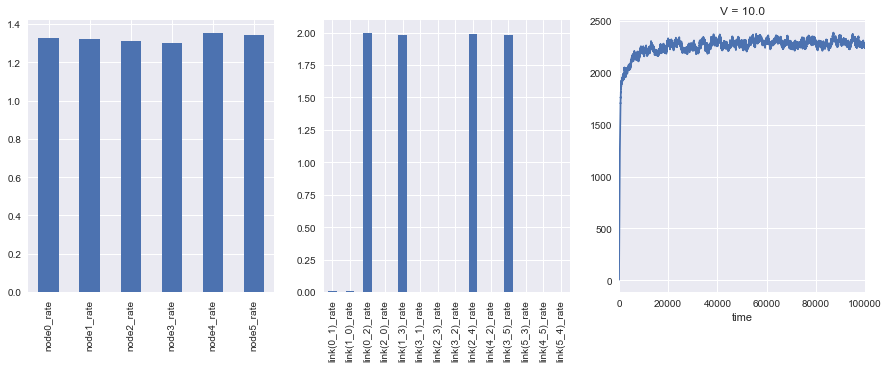

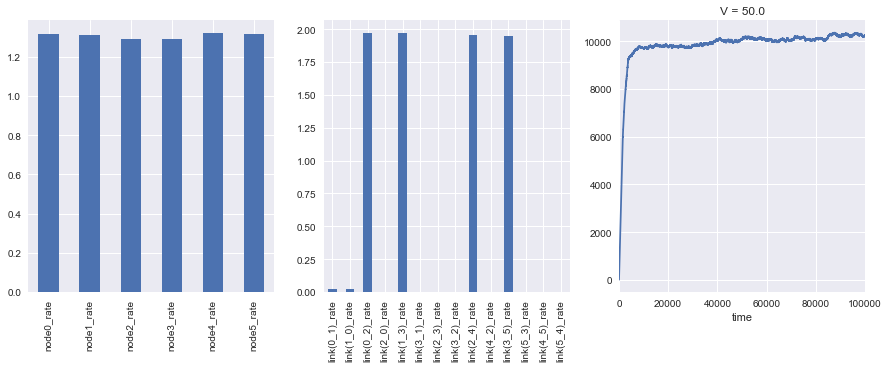

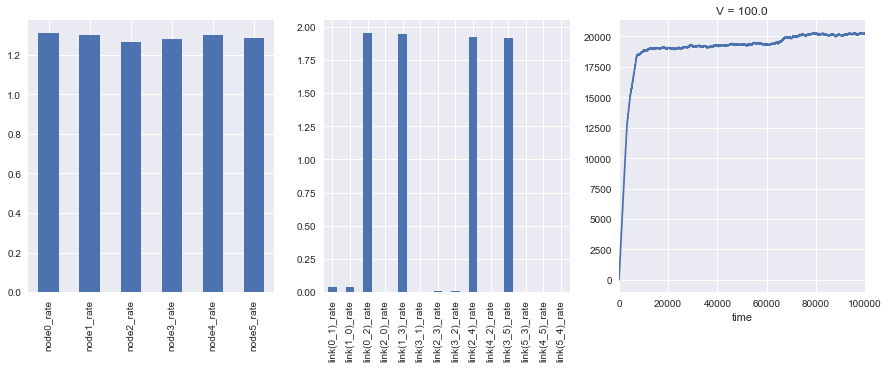

In [25]:
costs = []
queues = []
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
for V in Vs:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

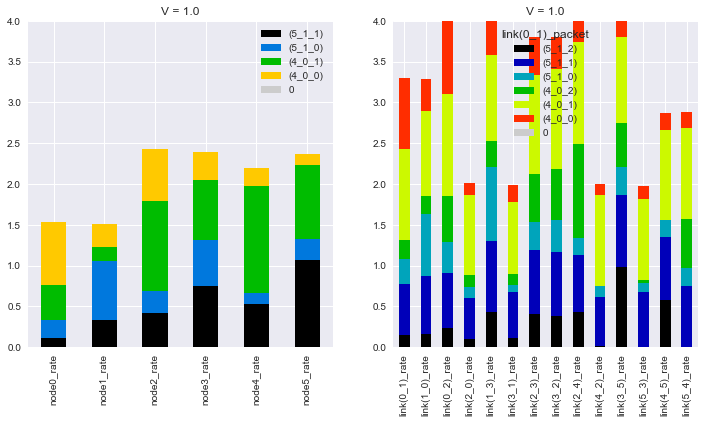

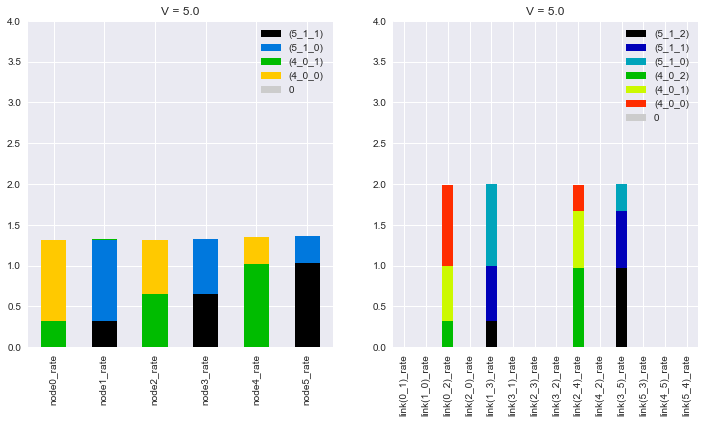

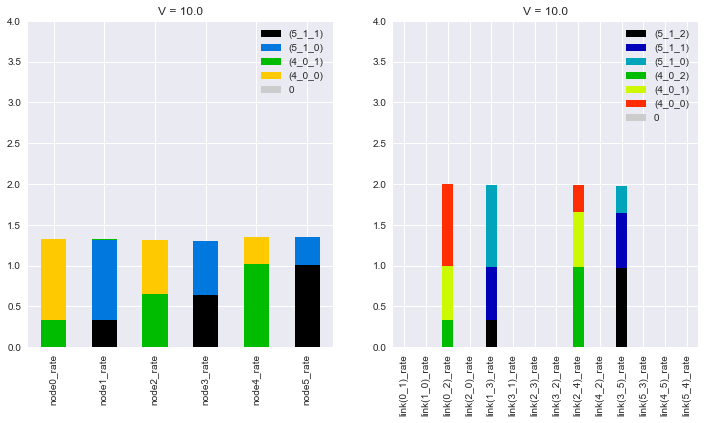

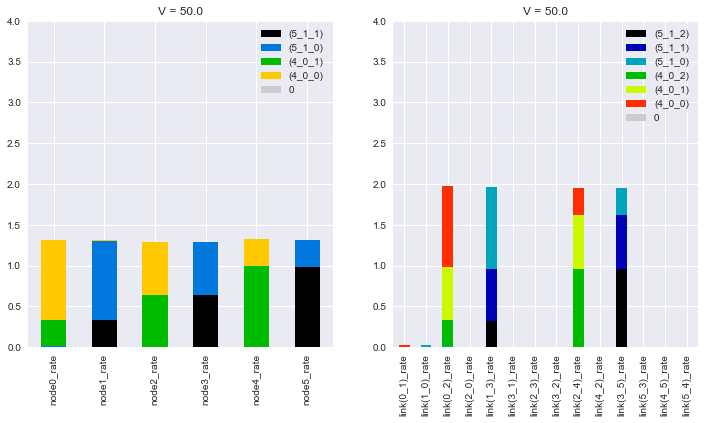

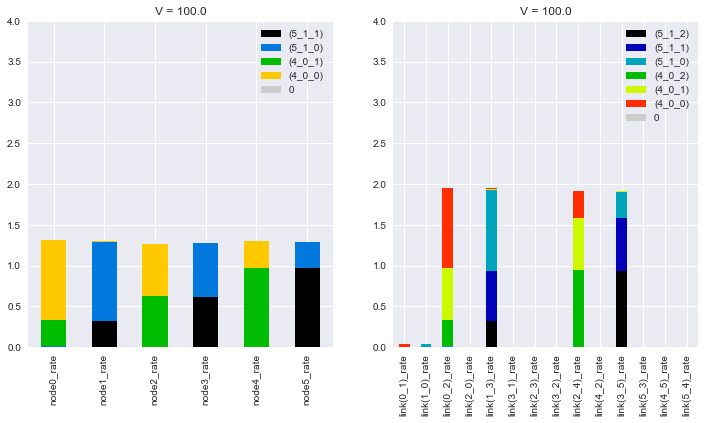

In [27]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)